# A computational method for optimal selection of Kernel Density Estimator bandwidth

In this work we propose a computational method for optimal selection of Kernel Density Estimator (KDE) bandwidth based on a Mean Squared Error (MSE) cross-validation process.

The need for a custom computational method not based on an analytical approach is caused by the inefficiency of existing analytical approaches to describe the actual data at hand in this research.

## Import required libraries

In [40]:
# General Python libraries required
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import os

from IPython.display import display

import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.neighbors import KernelDensity
from pathlib import Path

# Get current working directory path for the tool parent folder and print it.
parent_folder = 'Tool'
cwd = str(Path(os.getcwd()[:os.getcwd().index(parent_folder)+len(parent_folder)]))
print('Parent working directory: %s' % cwd)

# Import custom libraries from local folder.
import sys
sys.path.append("..")

from library.irplib import bw_selection as bws, utils

Parent working directory: /Users/jjrr/Documents/SCA-Project/Tool


## Set-up visualization options for pandas and matplotlib

In [3]:
# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
 
# Set pandas DataFrame visualization parameters
pd.options.display.max_columns = None

# Set rendering parameters to use TeX font if not working on Juno app.
if not '/private/var/' in os.getcwd():
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)

## Import dataset

Import dataset from Kelvin's Collision Avoidance Challenge (European Space Agency - ESA) and extract a subset of data containing only the last CDM of every event under the assumption it will contain the most accurate and up to date orbital elements data.

In [4]:
# Import training dataset
df = pd.read_csv(os.path.join(cwd,'data','esa-challenge','train_data.csv'), 
                 sep=',', header=0, index_col=None, skipinitialspace=False)

# Sort values of dataframe by event_id and time_to_tca and re-index
df.sort_values(by=['event_id', 'time_to_tca'], axis='index', 
               ascending=[True,False], inplace=True, ignore_index=True)

# Get only last CDM data from every event_id
df_lastCDM = df.drop_duplicates('event_id', keep='last')

# Show first rows of entire dataset and dataset with last CDMs only
display(df.head(10))
display(df_lastCDM.head(10))


,event_id,time_to_tca,mission_id,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_rcs_estimate,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,t_crdot_r,t_crdot_t,t_crdot_n,t_ctdot_r,t_ctdot_t,t_ctdot_n,t_ctdot_rdot,t_cndot_r,t_cndot_t,t_cndot_n,t_cndot_rdot,t_cndot_tdot,c_object_type,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_rcs_estimate,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,c_crdot_r,c_crdot_t,c_crdot_n,c_ctdot_r,c_ctdot_t,c_ctdot_n,c_ctdot_rdot,c_cndot_r,c_cndot_t,c_cndot_n,c_cndot_rdot,c_cndot_tdot,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP
0,0,1.566798,5,-10.204955,-7.834756,8.602101,14923.0,13792.0,453.8,5976.6,-13666.8,-7.2,-12637.0,-5525.9,1.0,0.0,3.78,3.78,459,458,98.9,1.265,0.4020,0.013826,0.007173,0.000051,6996.918867,0.003997,97.806412,-0.397969,0.292258,0.040799,0.394221,-0.999674,-0.038498,-0.981098,0.214612,-0.316493,-0.210247,0.170737,-0.001551,0.531593,0.002117,-0.179278,UNKNOWN,180.0,2.0,15.85,15.85,15.0,15.0,100.0,2.360,NaN,0.348701,0.126607,0.001406,7006.607320,0.003144,74.045735,-0.824859,0.473976,-0.002576,0.825216,-0.999998,0.003565,-0.732954,0.220006,-0.814249,-0.220621,0.249855,0.196620,0.722186,-0.196908,-0.668487,1.0,2.0,646.745439,590.818294,650.497251,606.443389,-73.574095,-23.618769,0.029910,129.430951,7.373471e+05,4.429923e+16,4.057932,266.722309,137.617114,54366.864909,1.781418,46.612573,0.147350,58.272095,0.004092,0.165044,0.002987,0.386462,89.0,83.0,42.0,11.0
1,0,1.207494,5,-10.355758,-7.848937,8.956374,14544.0,13792.0,474.3,5821.2,-13319.8,-7.0,-12637.0,-5525.9,1.0,0.0,3.79,3.79,456,455,98.5,1.270,0.4020,0.013487,0.009139,0.000060,6996.920255,0.003996,97.806420,-0.073137,0.297366,0.060541,0.069652,-0.998192,-0.052511,-0.994240,-0.029644,-0.302333,0.034030,0.179696,0.001552,0.561142,-0.005165,-0.181036,UNKNOWN,180.0,2.0,15.85,15.85,15.0,15.0,100.0,2.360,NaN,0.348701,0.126607,0.001406,7006.621053,0.003144,74.045736,-0.818207,0.482754,-0.003578,0.818573,-0.999998,0.004574,-0.728759,0.202595,-0.817490,-0.203216,0.258964,0.195718,0.721903,-0.196008,-0.674979,1.0,2.0,646.743506,590.823004,650.513314,606.454793,-73.570690,-23.618769,0.029079,271.540424,1.141390e+05,4.378610e+16,3.526780,262.191819,56.070117,54082.067268,1.800959,46.595869,0.059672,57.966413,0.003753,0.164383,0.002933,0.386393,89.0,83.0,42.0,11.0
2,0,0.952193,5,-10.345631,-7.847406,8.932195,14475.0,13792.0,474.6,5796.2,-13256.1,-7.0,-12637.0,-5525.9,1.0,0.0,3.79,3.80,456,455,98.5,1.257,0.4020,0.013357,0.007057,0.000060,6996.920553,0.003996,97.806418,-0.109230,0.305189,0.043711,0.107079,-0.996235,-0.034287,-0.996674,0.033933,-0.308501,-0.030161,0.123760,0.019630,0.579274,-0.023726,-0.125737,UNKNOWN,180.0,2.0,15.85,15.85,15.0,15.0,100.0,2.360,NaN,0.348701,0.126607,0.001406,7006.623524,0.003144,74.045737,-0.817408,0.483828,-0.003742,0.817774,-0.999998,0.004738,-0.729083,0.201698,-0.817662,-0.202320,0.260092,0.195558,0.721854,-0.195849,-0.675347,1.0,2.0,646.745607,590.821499,650.515082,606.457965,-73.570088,-23.618769,0.029079,347.899292,4.696004e+04,4.369105e+16,3.362037,261.666544,37.497947,54027.391201,1.821940,46.592757,0.039258,57.907599,0.003576,0.164352,0.002967,0.386381,89.0,83.0,42.0,11.0
3,0,0.579669,5,-10.337809,-7.845880,8.913444,14579.0,13792.0,472.7,5838.9,-13350.7,-7.0,-12637.0,

,event_id,time_to_tca,mission_id,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_rcs_estimate,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,t_crdot_r,t_crdot_t,t_crdot_n,t_ctdot_r,t_ctdot_t,t_ctdot_n,t_ctdot_rdot,t_cndot_r,t_cndot_t,t_cndot_n,t_cndot_rdot,t_cndot_tdot,c_object_type,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_rcs_estimate,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,c_crdot_r,c_crdot_t,c_crdot_n,c_ctdot_r,c_ctdot_t,c_ctdot_n,c_ctdot_rdot,c_cndot_r,c_cndot_t,c_cndot_n,c_cndot_rdot,c_cndot_tdot,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP
4,0,0.257806,5,-10.391260,-7.852942,9.036838,14510.0,13792.0,478.7,5811.1,-13288.0,-7.0,-12637.0,-5525.9,1.0,0.0,3.86,3.86,440,439,98.8,1.340,0.4020,0.013906,0.007339,0.000068,6996.920446,0.003996,97.806426,0.417865,0.406002,0.246911,-0.465256,-0.983144,-0.243006,-0.999749,-0.430895,-0.405723,0.479990,0.223469,0.118674,0.543475,-0.143542,-0.224060,UNKNOWN,180.0,2.0,15.85,15.85,15.0,15.0,100.0,2.360,NaN,0.348701,0.126607,0.001406,7006.626646,0.003144,74.045736,-0.815980,0.485794,-0.004081,0.816347,-0.999998,0.005077,-0.727257,0.196662,-0.818575,-0.197284,0.261753,0.195657,0.721794,-0.195947,-0.677041,1.00,2.0,646.745868,590.821024,650.519613,606.459678,-73.570409,-23.618769,0.029079,469.178802,7.827098e+03,4.374142e+16,3.392176,260.727425,16.110807,54063.675421,1.958295,46.594699,0.015075,57.946717,0.003670,0.164172,0.003220,0.386388,89.0,83.0,40.0,14.0
8,1,3.570013,5,-9.248105,-7.327533,7.425994,26899.0,3434.0,-82.0,-26067.0,6638.2,56.8,-847.8,-3328.2,1.0,0.0,4.04,4.04,430,429,99.0,1.402,0.4030,0.015178,0.003417,0.000031,7001.561205,0.001028,97.767002,0.025433,0.318842,0.027919,-0.050648,-0.997384,-0.040625,-0.999560,-0.053437,-0.319966,0.079098,0.016432,-0.049850,0.760496,0.046685,-0.015341,DEBRIS,1.0,0.0,3.54,3.55,33.0,33.0,100.0,1.650,0.0045,0.151857,0.000000,0.008730,6880.588349,0.017491,82.431524,-0.896007,-0.341763,0.075631,0.895993,-1.000000,-0.075170,-0.982560,0.962694,0.243049,-0.962685,-0.389578,0.249596,0.811324,-0.249363,0.344542,1.00,2.0,630.622566,616.225845,622.796659,382.106039,-54.109782,-75.708851,-0.947480,62.058087,5.097272e+06,8.825836e+15,5.455330,99.916400,115.552629,27824.072312,3.780796,97.159318,0.124802,30.242768,0.005883,0.174956,0.003408,0.058311,71.0,87.0,21.0,5.0
28,2,0.401947,2,-30.000000,-7.449283,37296.168207,18708.0,14347.0,-717.9,-5159.0,17968.9,14.4,-13791.4,-3957.2,1.0,0.0,3.56,3.56,481,481,99.1,1.056,3.4479,0.019441,0.014506,0.000013,7158.408492,0.000863,98.523055,0.170637,0.077322,0.044859,-0.301307,-0.945516,-0.007249,-0.999839,-0.187388,-0.076980,0.317338,0.101294,0.042436,-0.524384,-0.042744,-0.102280,UNKNOWN,1.0,0.0,14.56,14.56,18.0,18.0,100.0,1.733,NaN,0.858056,0.474456,0.000591,7168.395415,0.001298,69.718579,-0.733858,0.811887,-0.712991,0.677382,-0.935640,0.552588,-0.999956,0.728830,-0.812411,-0.671514,0.854603,-0.742879,0.966785,0.540052,-0.855151,12.00,2.0,786.448033,774.094951,799.560390,780.956440,63.902737,-16.009902,-0.057504,279.634916,1.440938e+03,1.080252e+12,2.800282,101.046821,9.139996,231.198248,1.510495,117.423294,0.009590,0.219821,0.002918,0.105403,0.002903,0.290009,70.0,77.0,0.0,4.0
49,3,0.283061,19,-30.000000,-8.439735,45859.719269,23861.0,13574.0,51.8,10055.9,21639.4,-39.6,-12310.

## Overview of non-parammetric features
Using the Exploratory Data Analysis (EDA) outputs over this dataset, a number of features that cannot be described using a parammetric approach have been identified. Therefore, the Kernel Density Estimator method will be used instead.

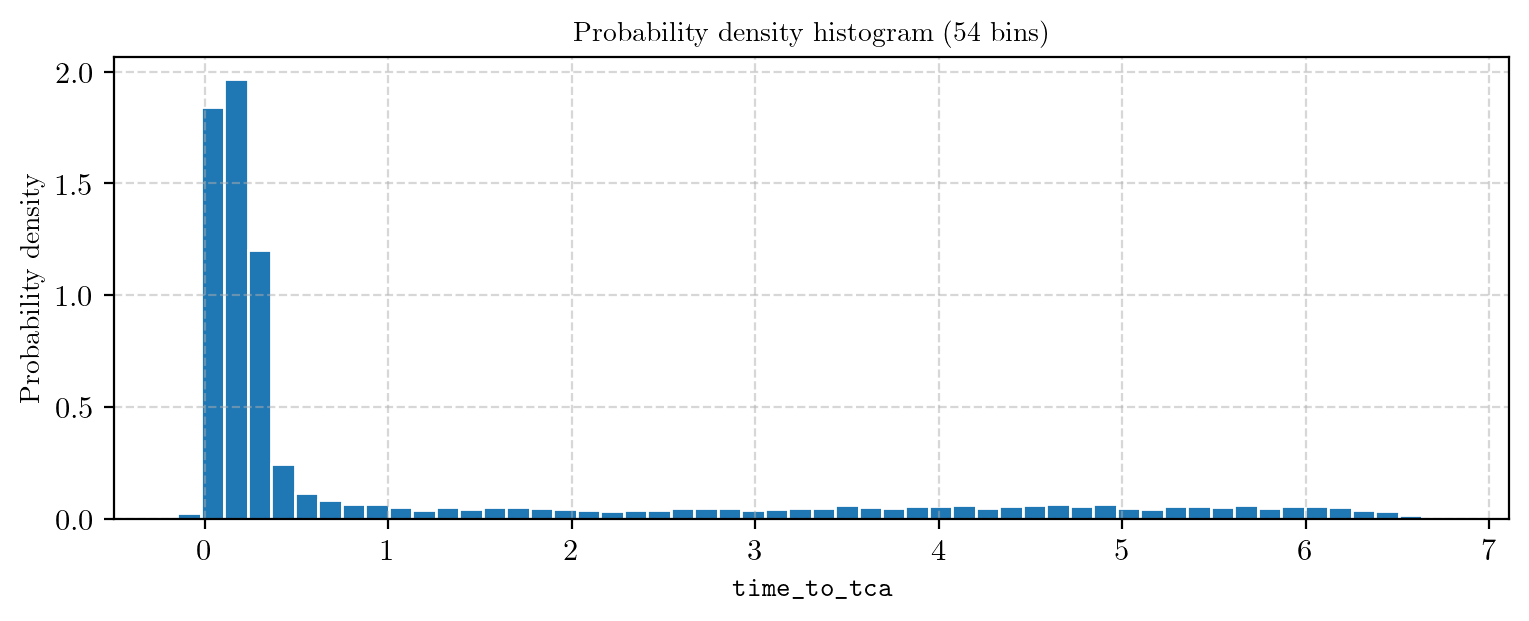

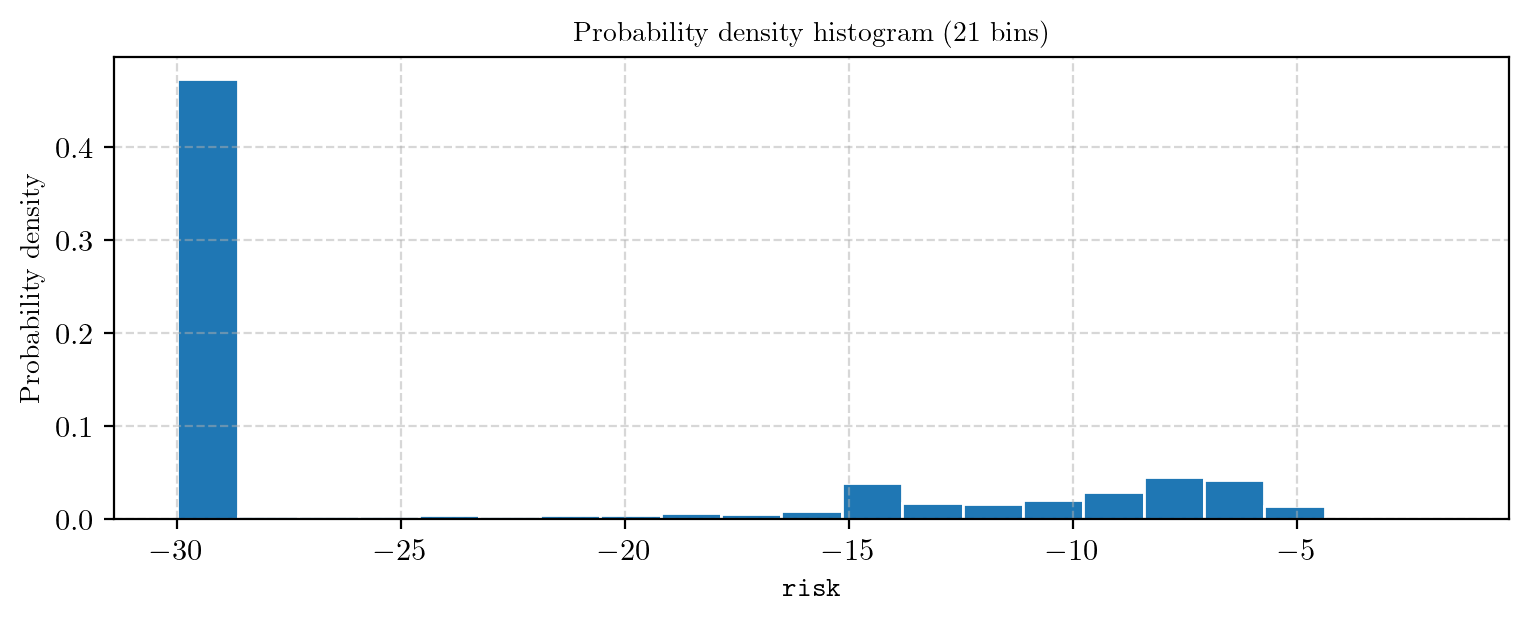

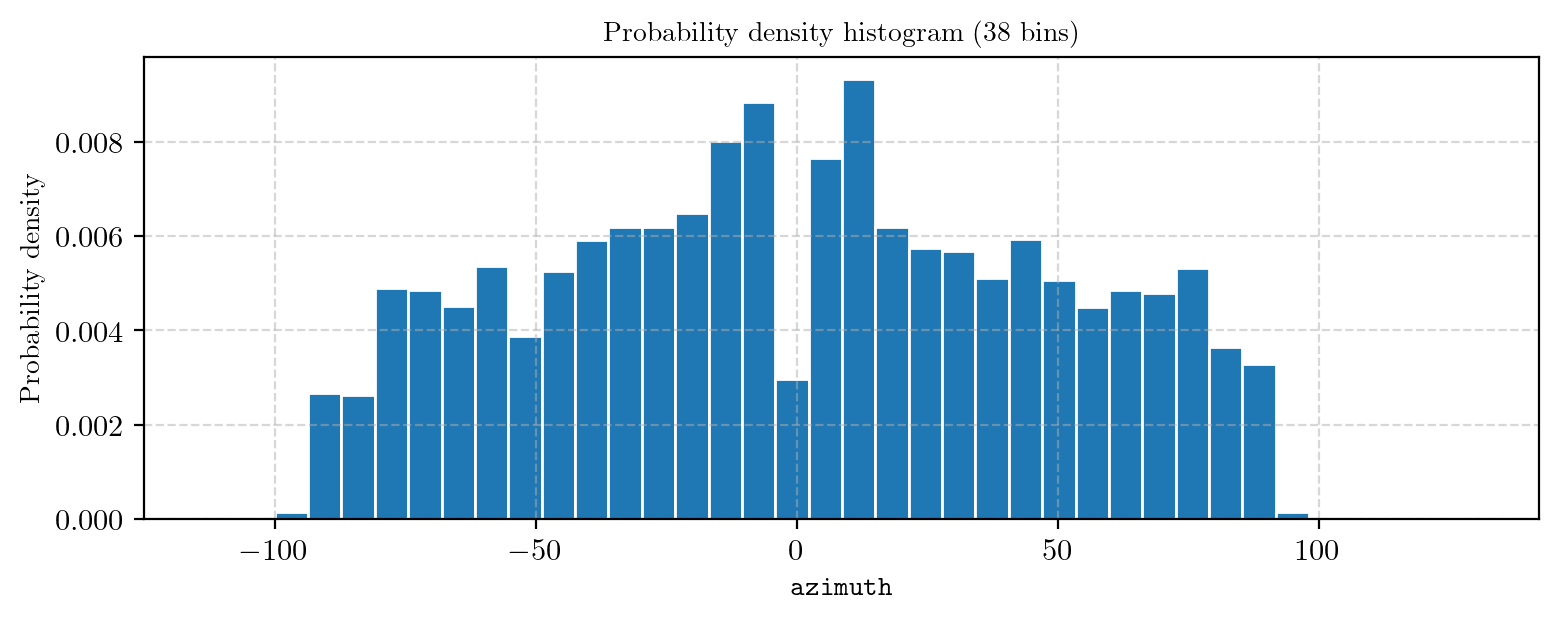

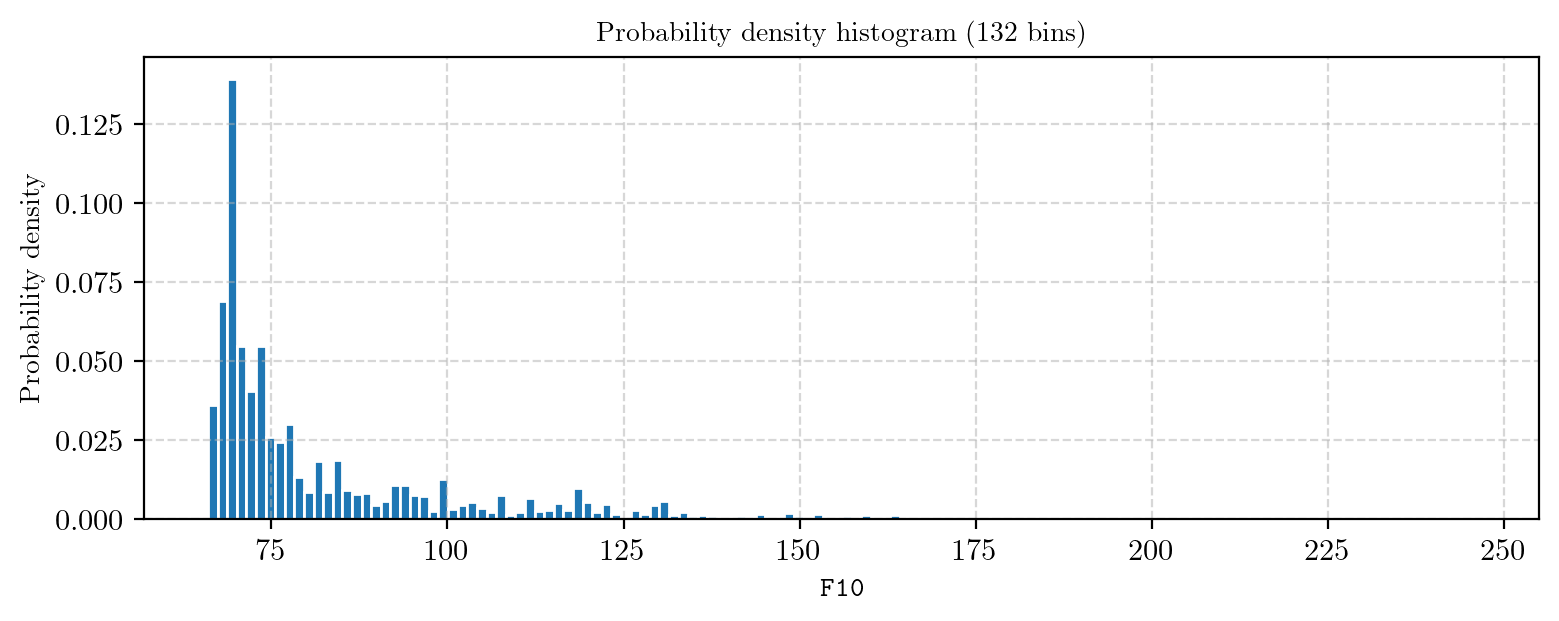

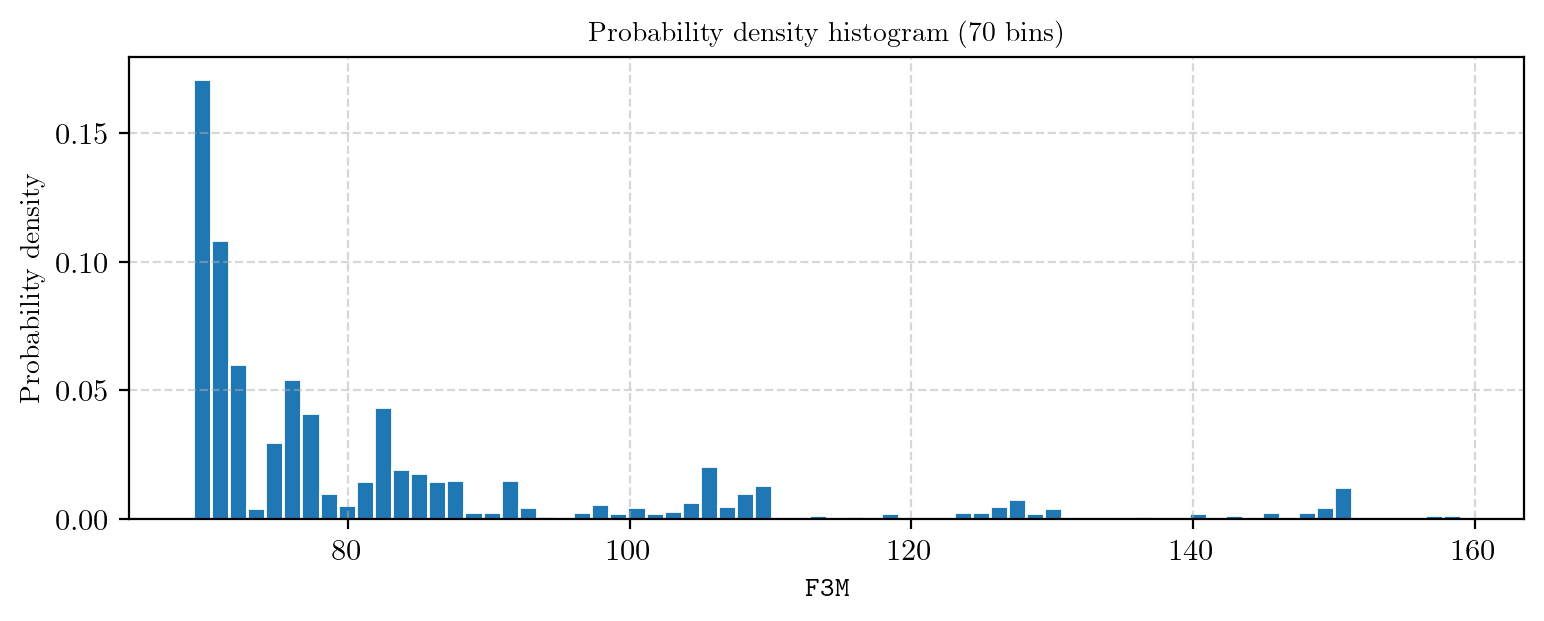

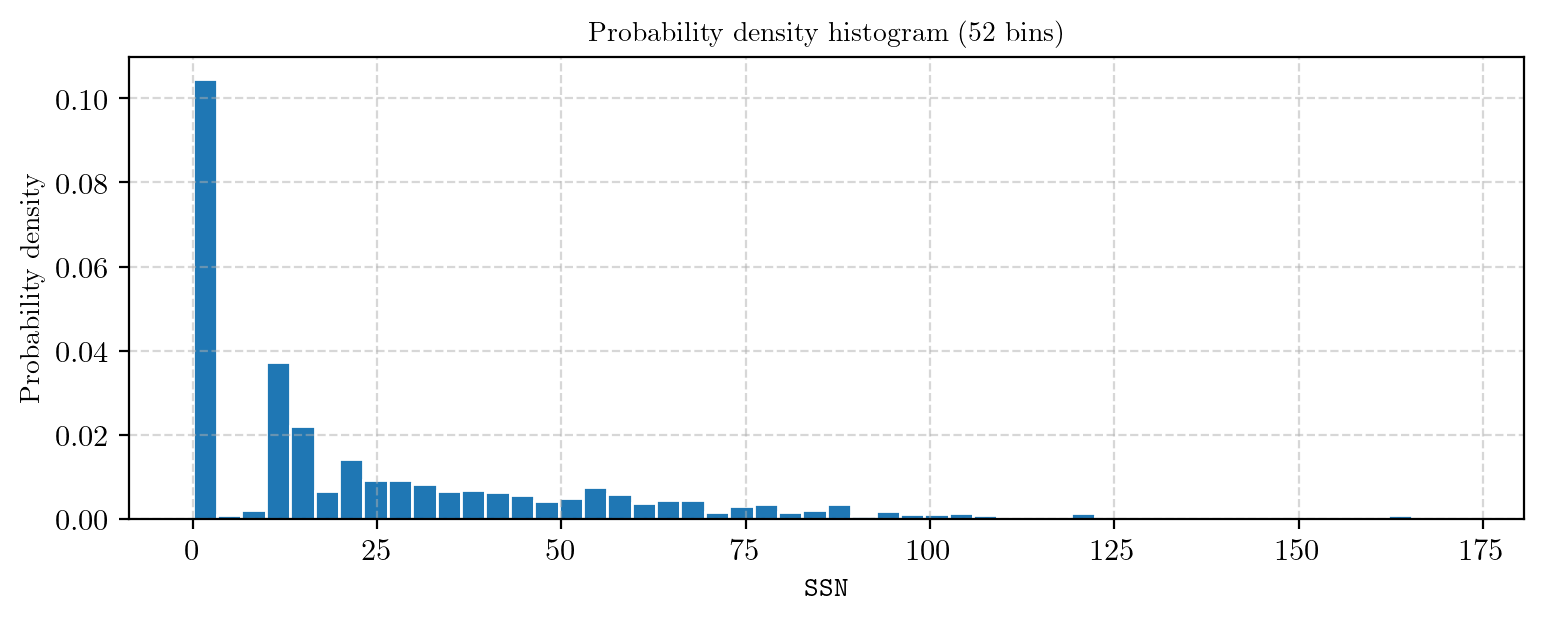

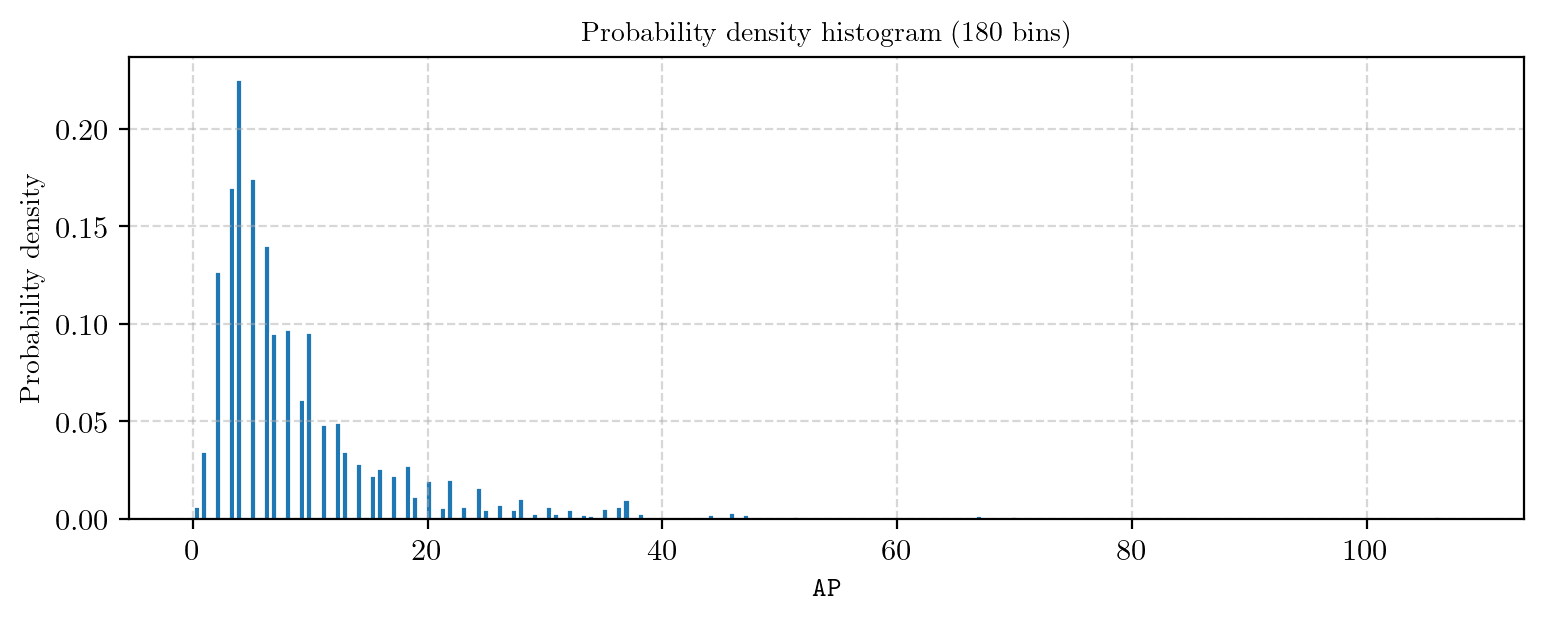

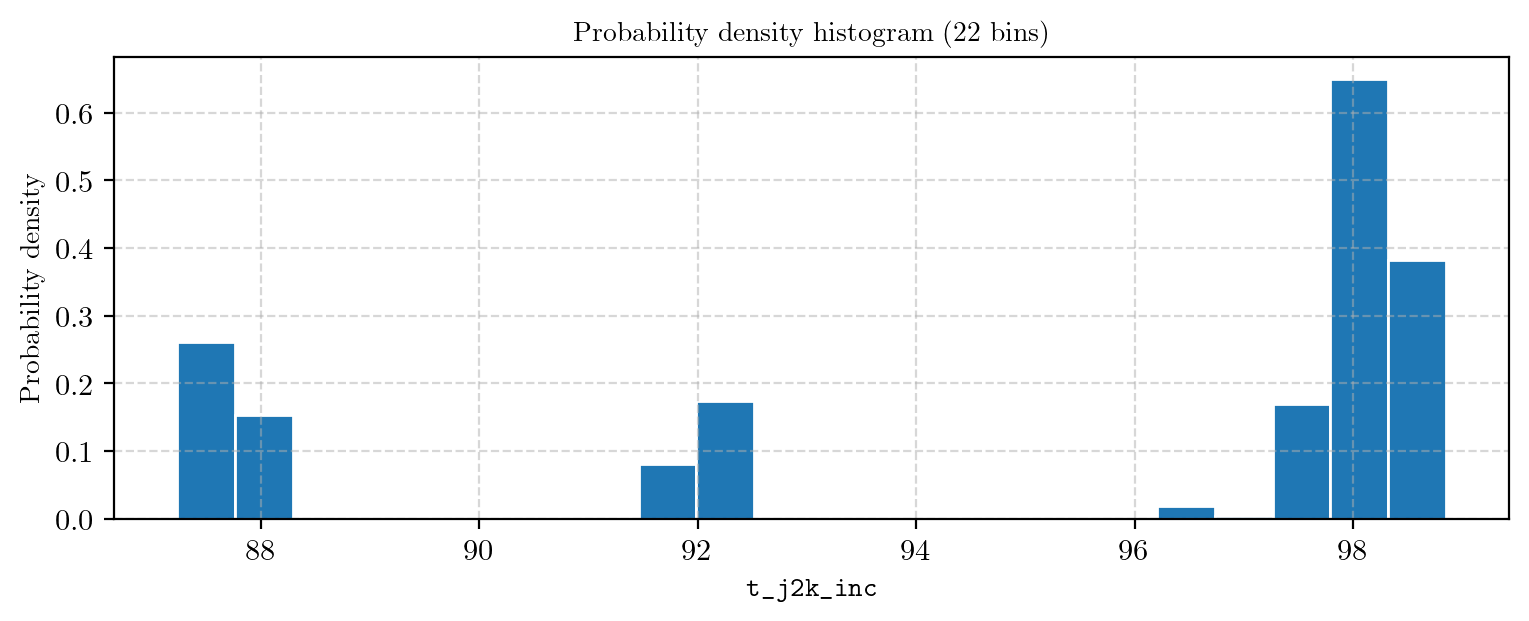

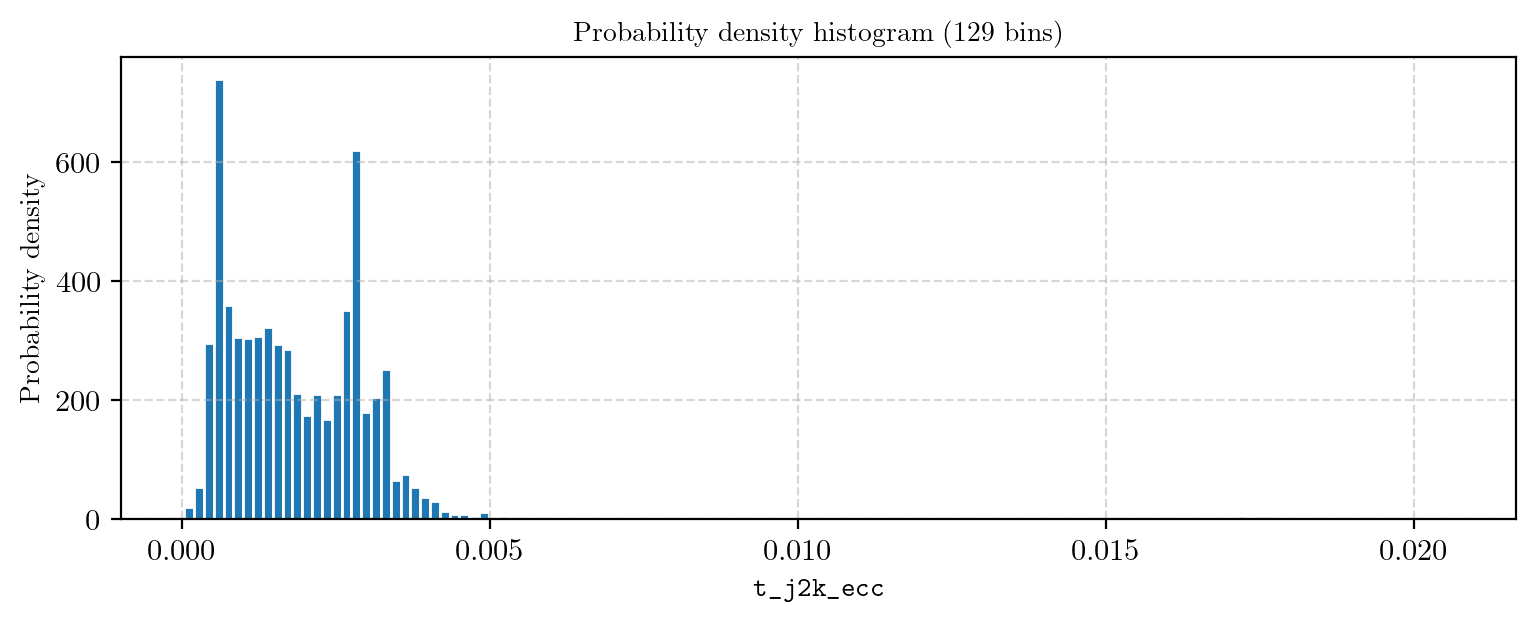

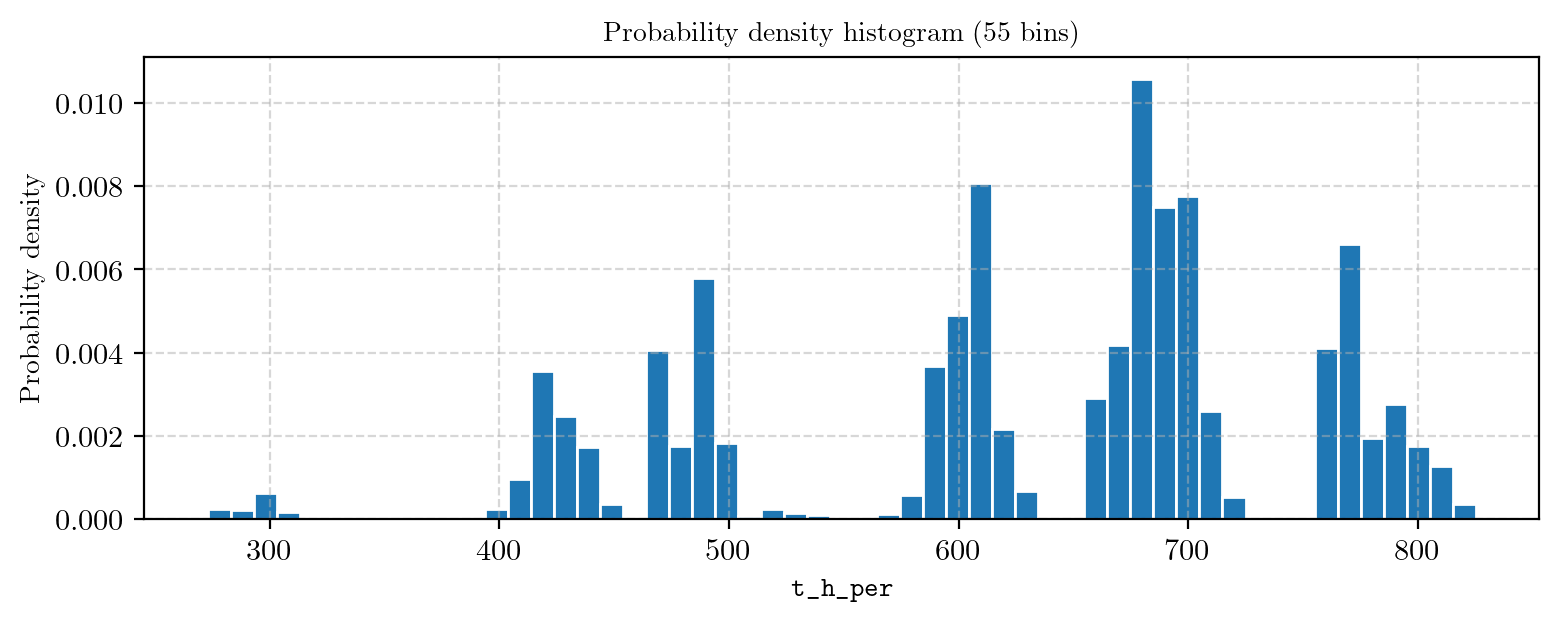

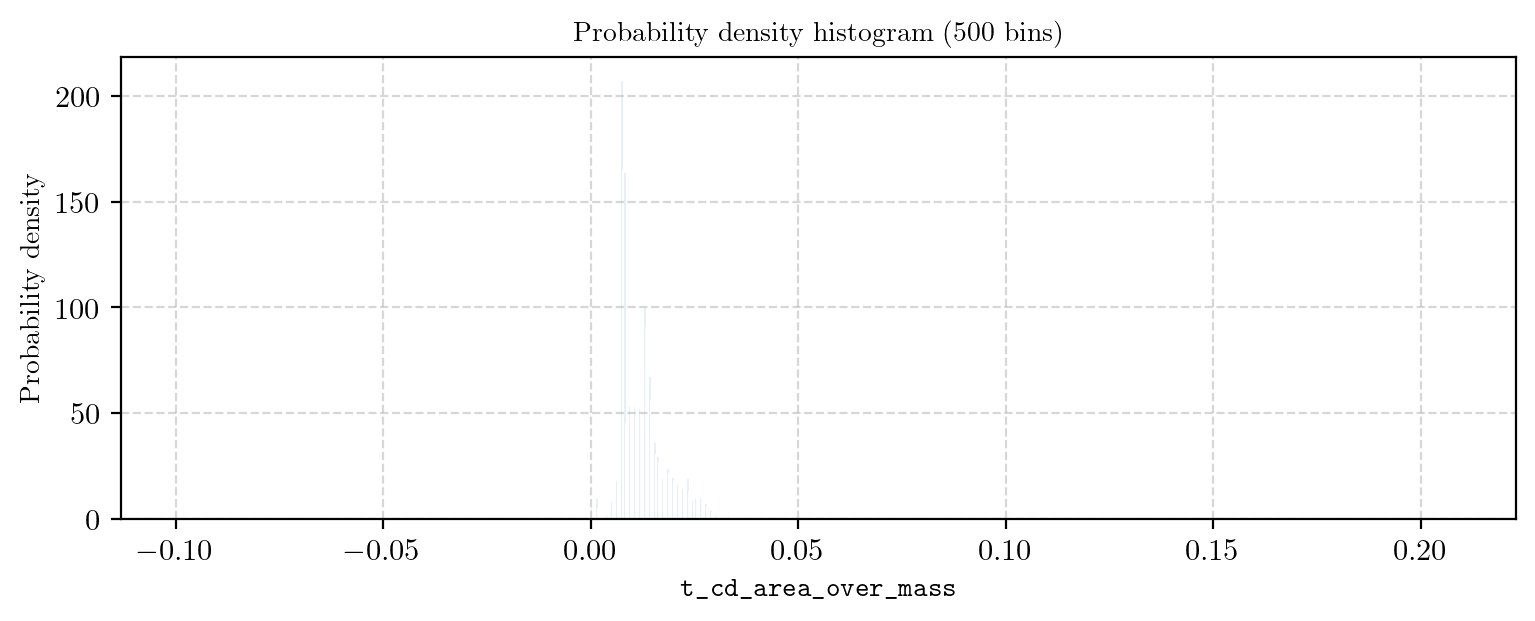

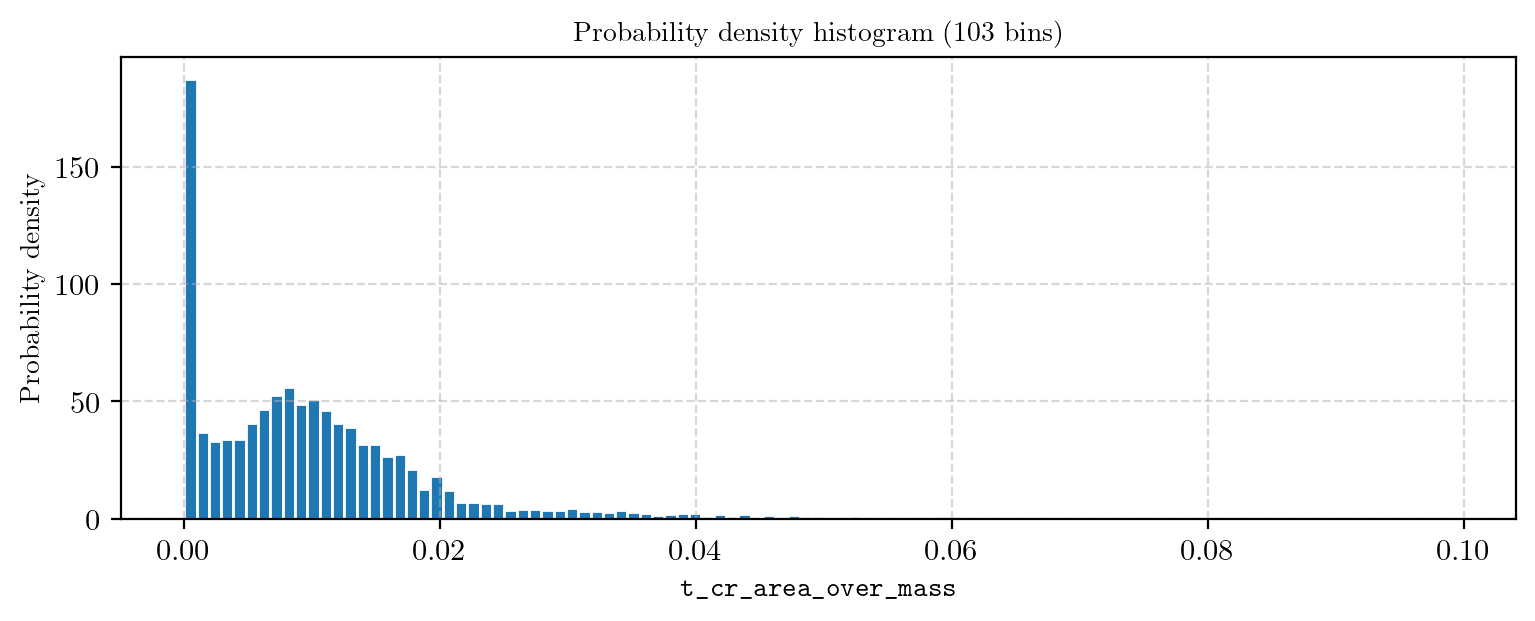

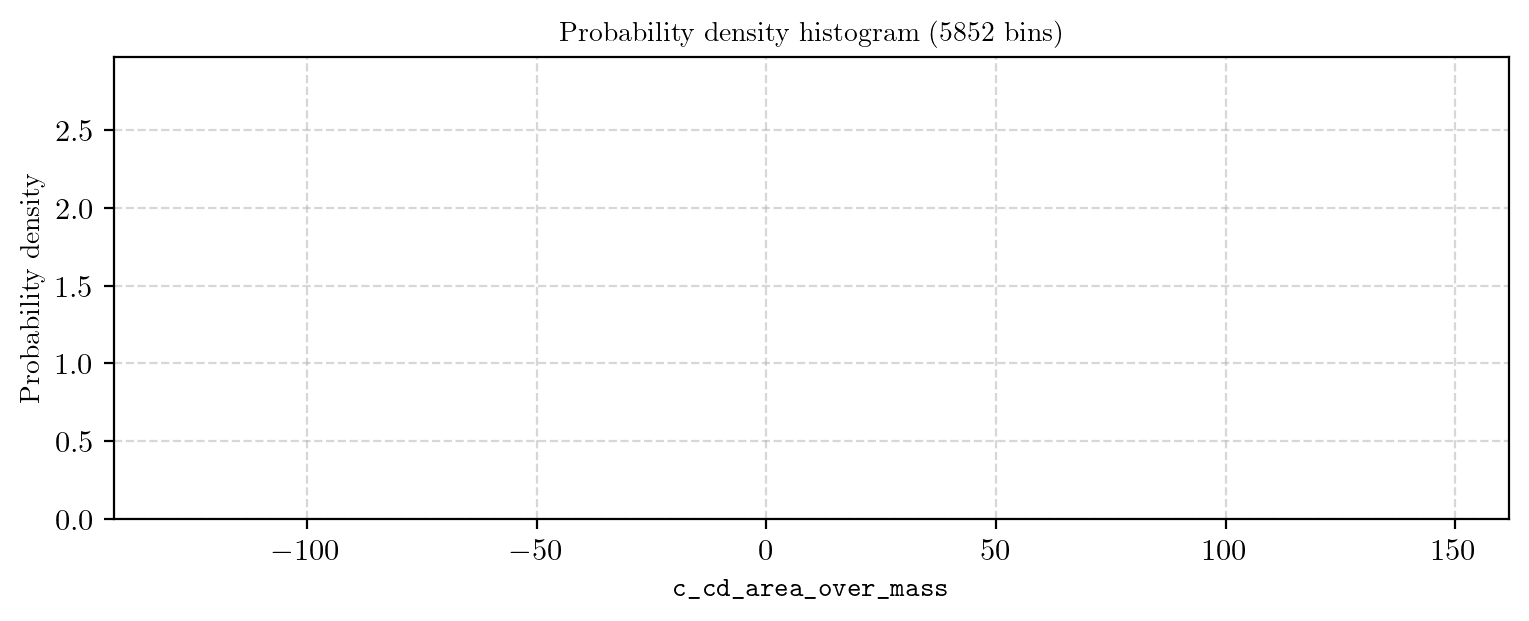

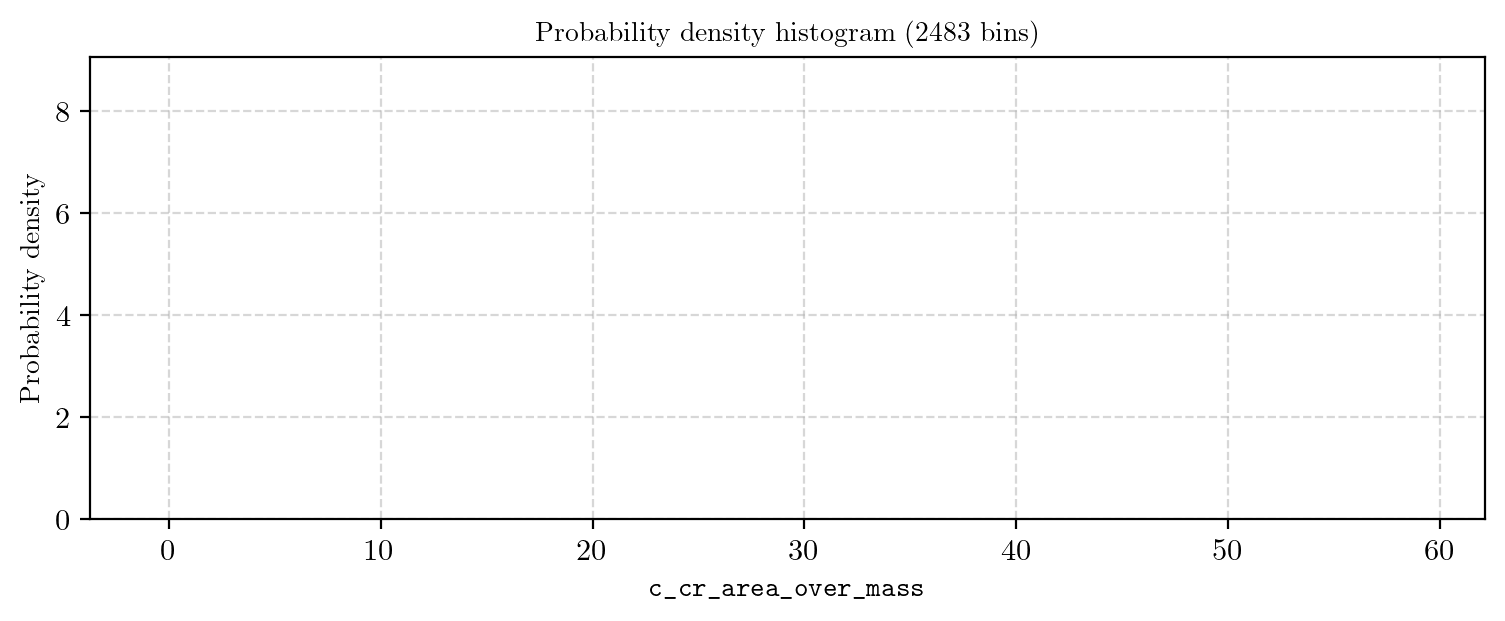

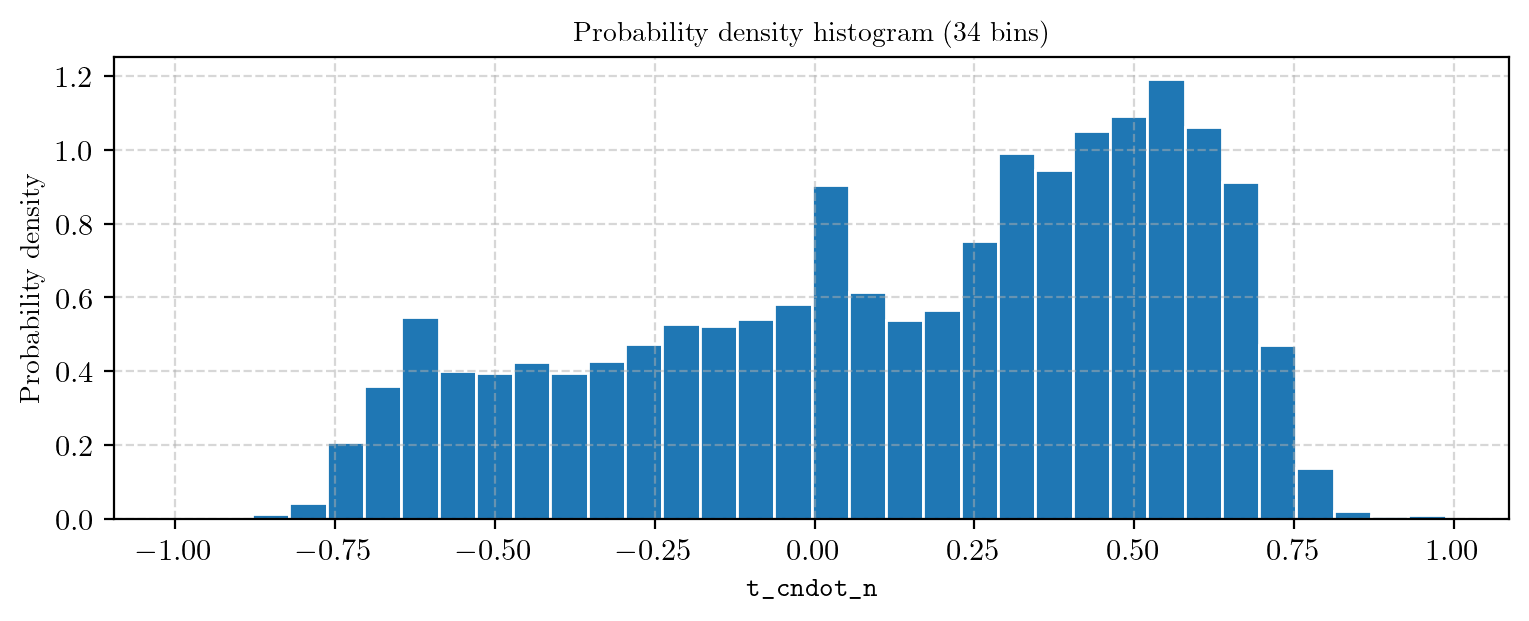

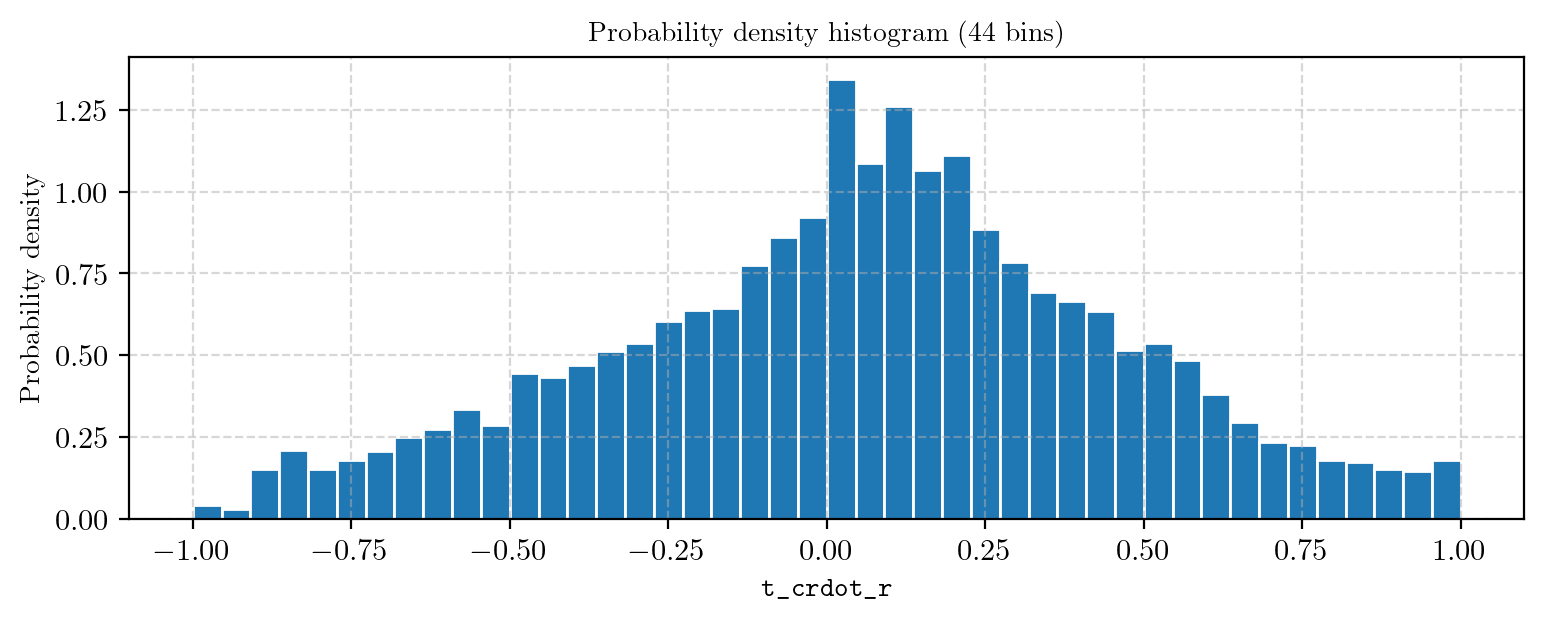

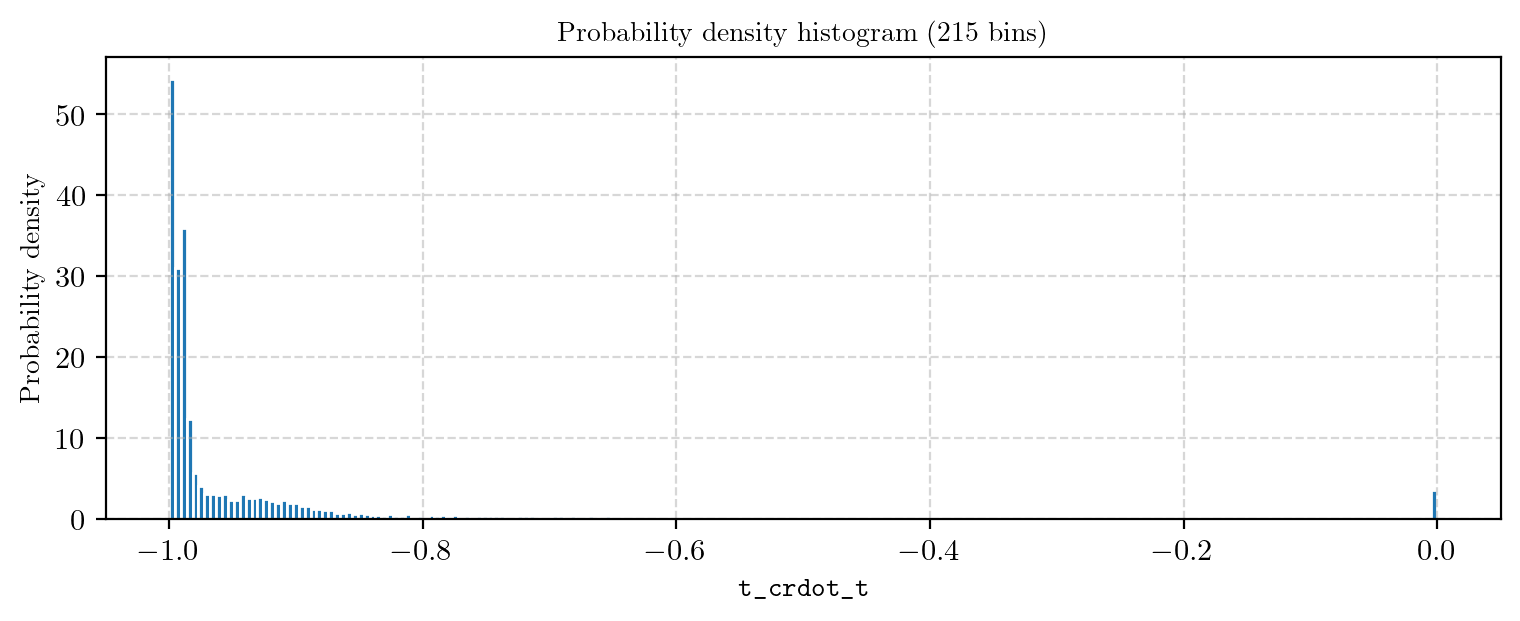

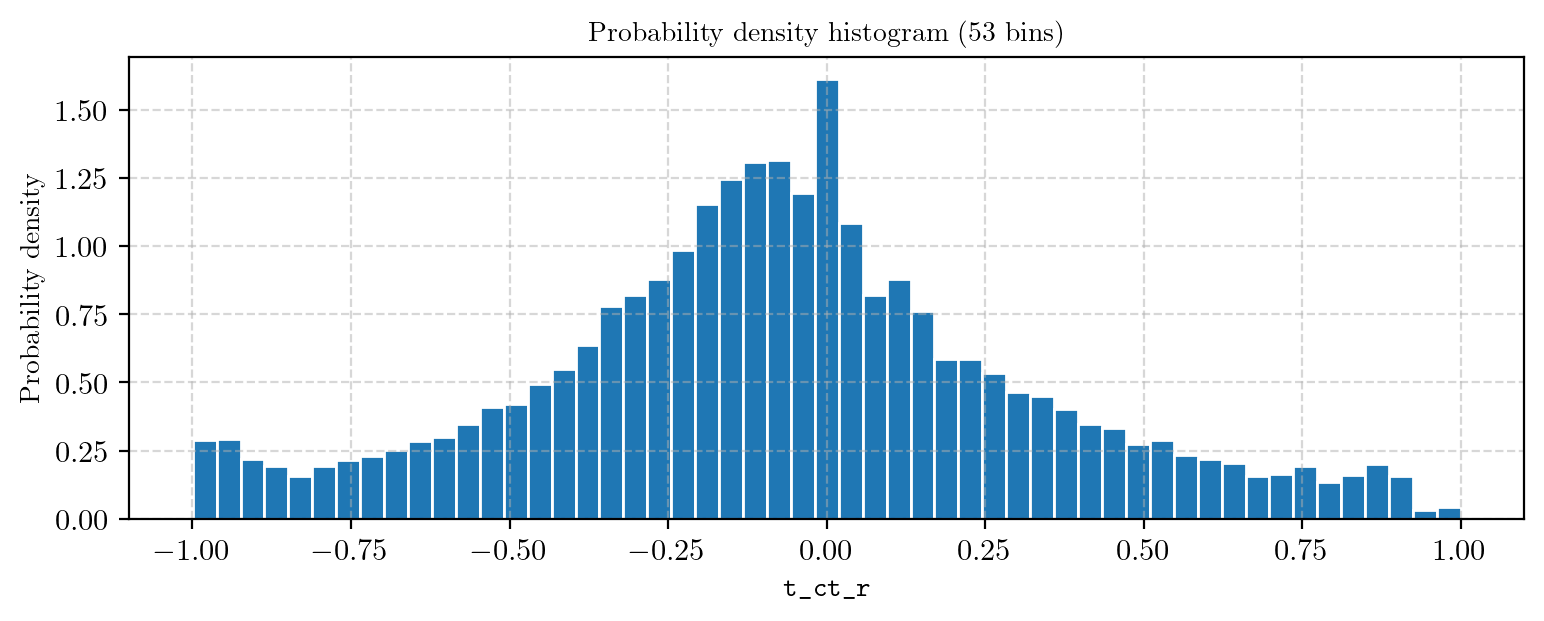

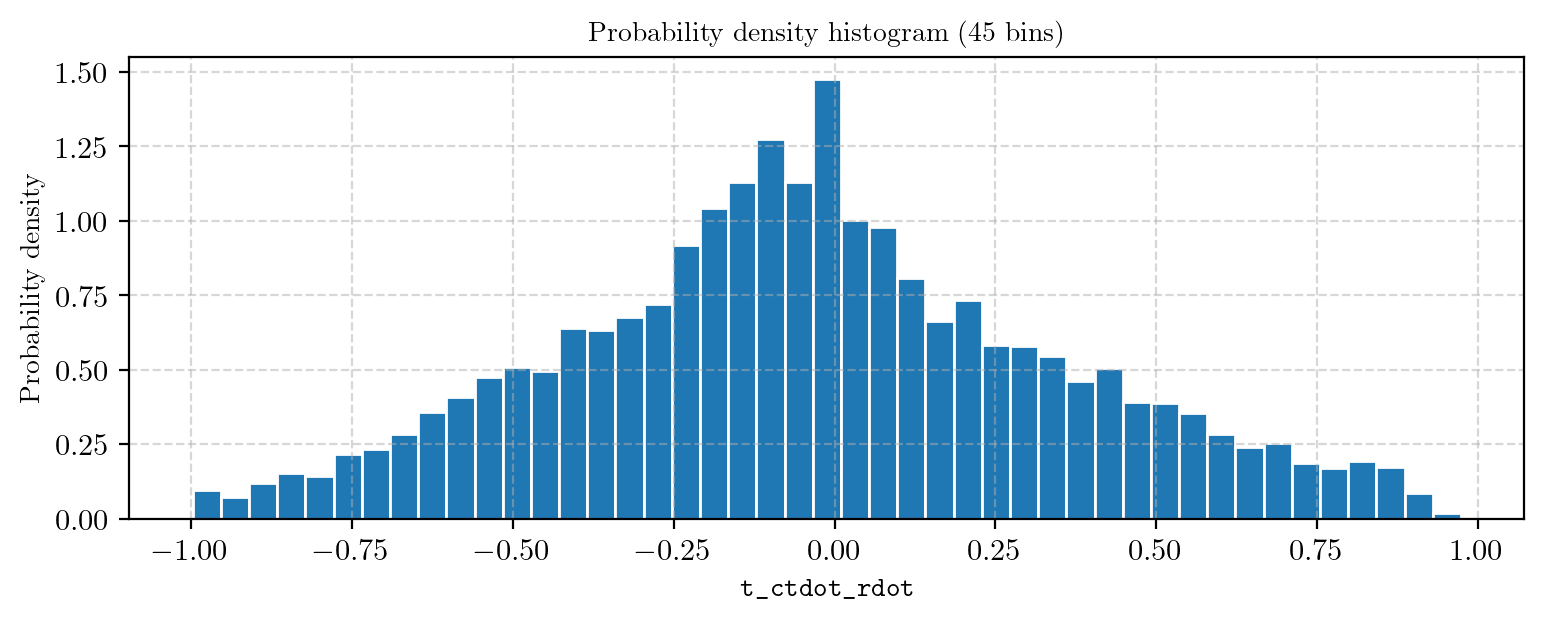

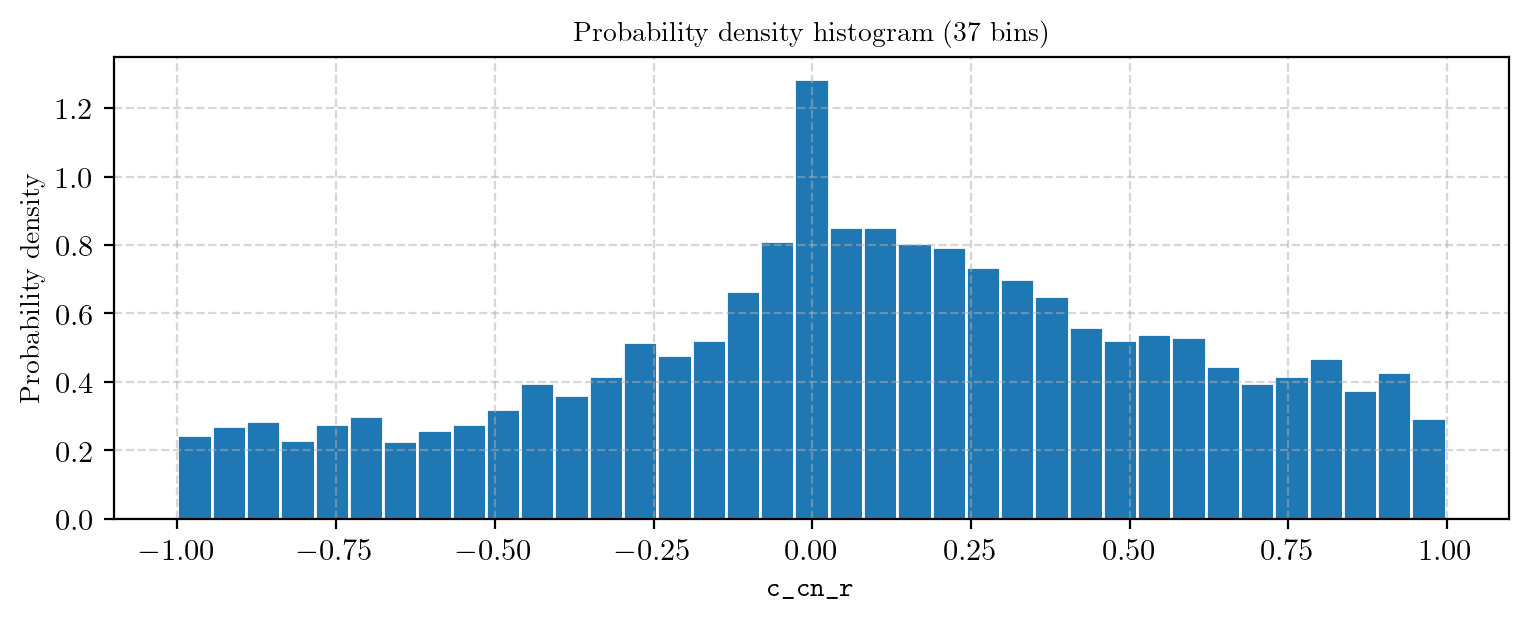

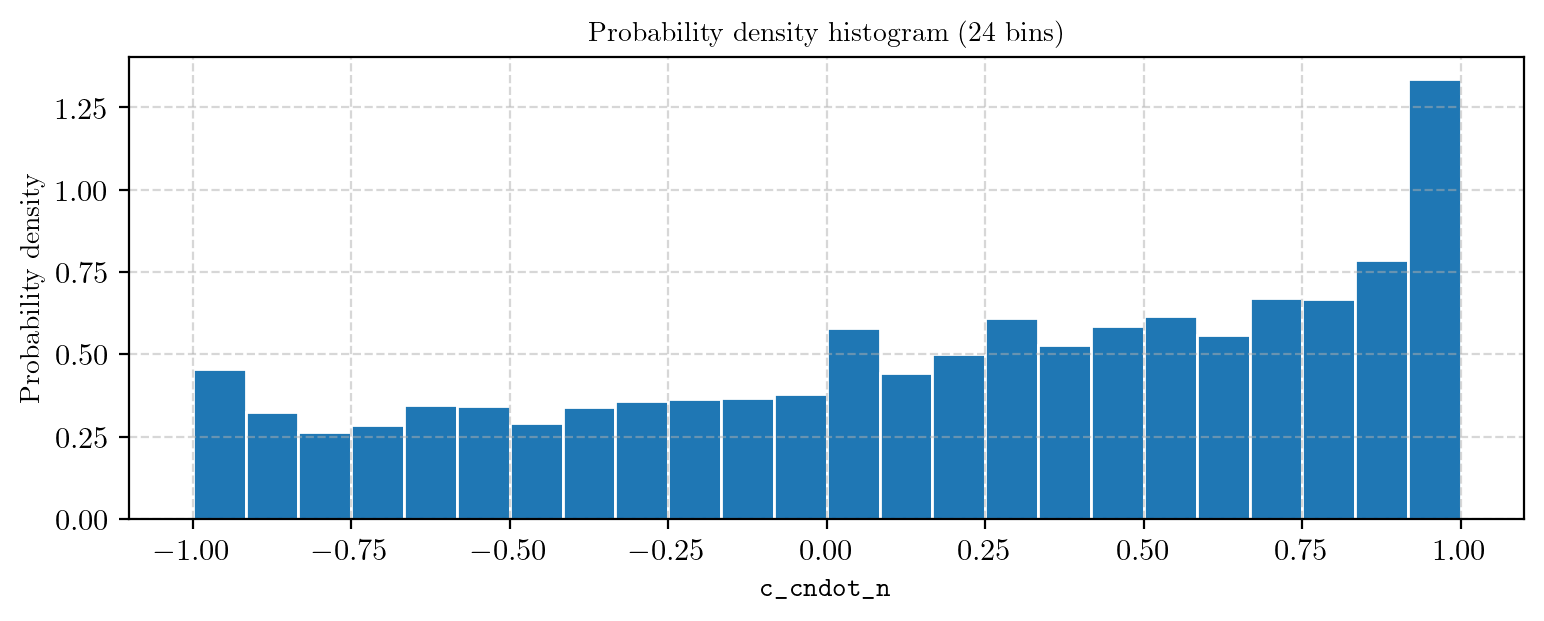

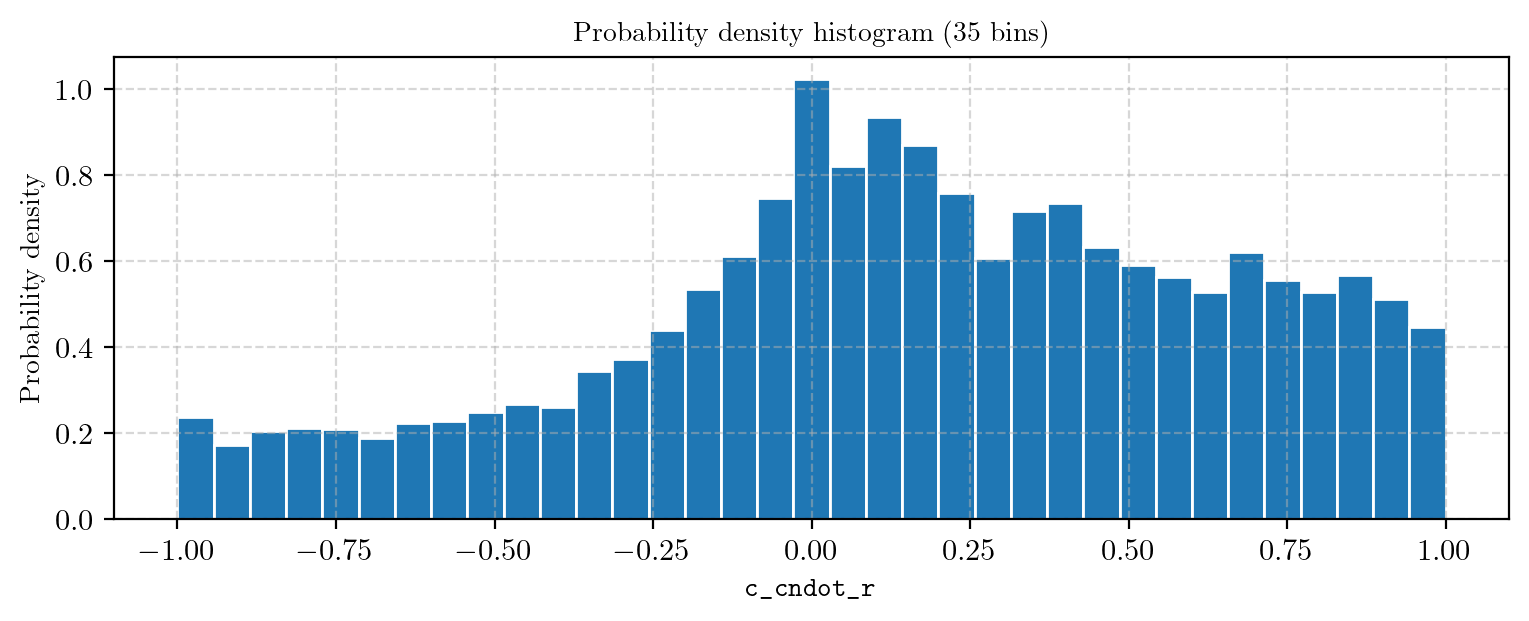

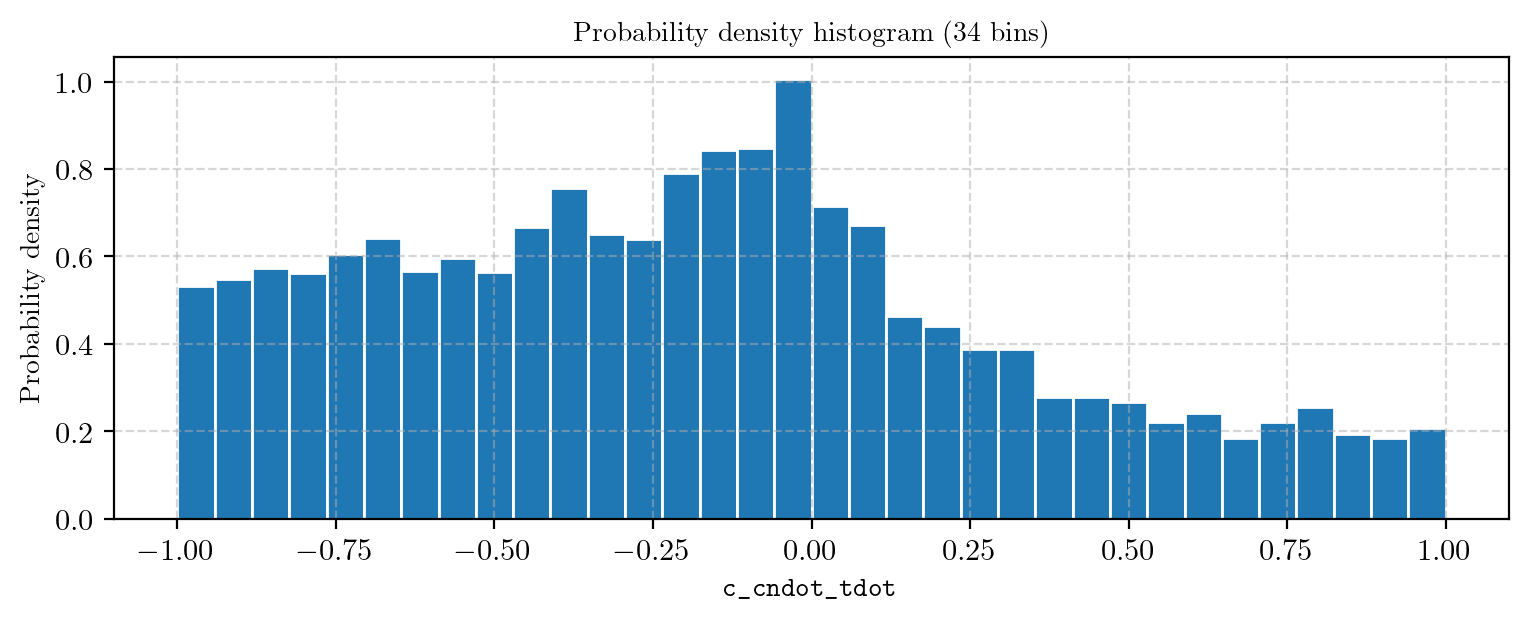

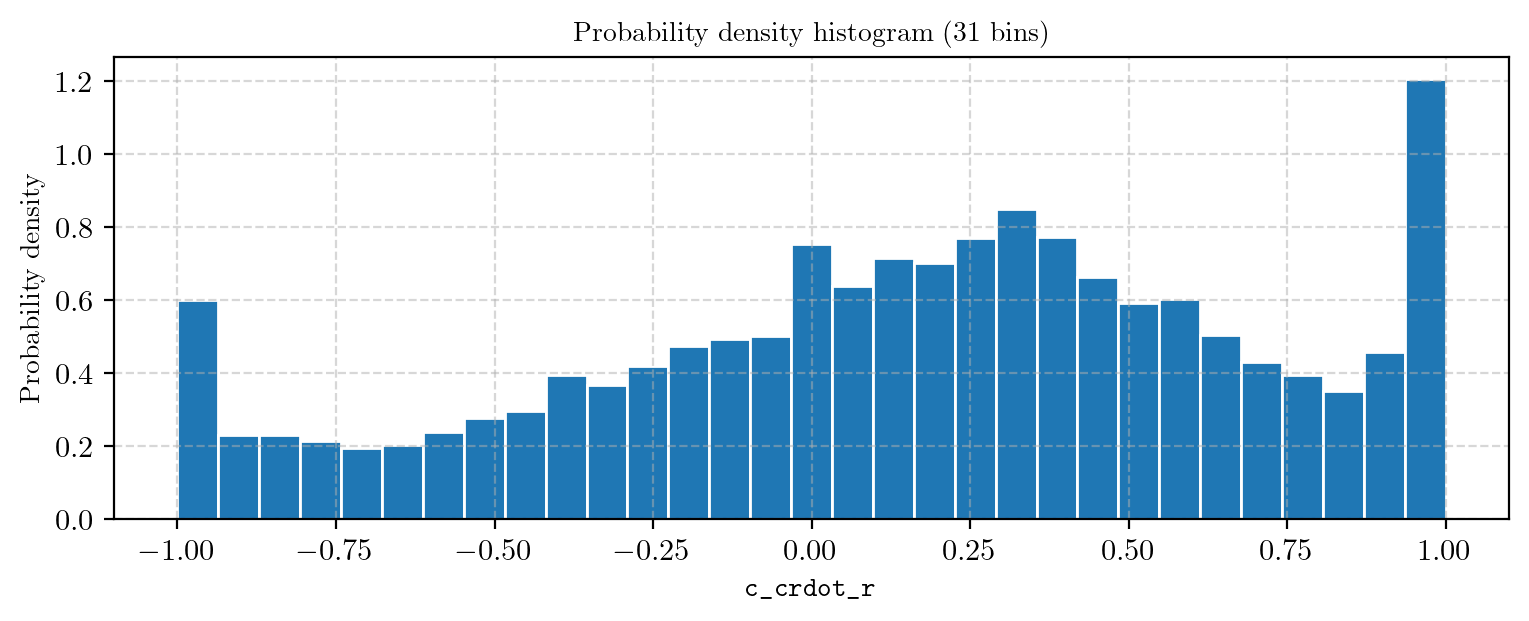

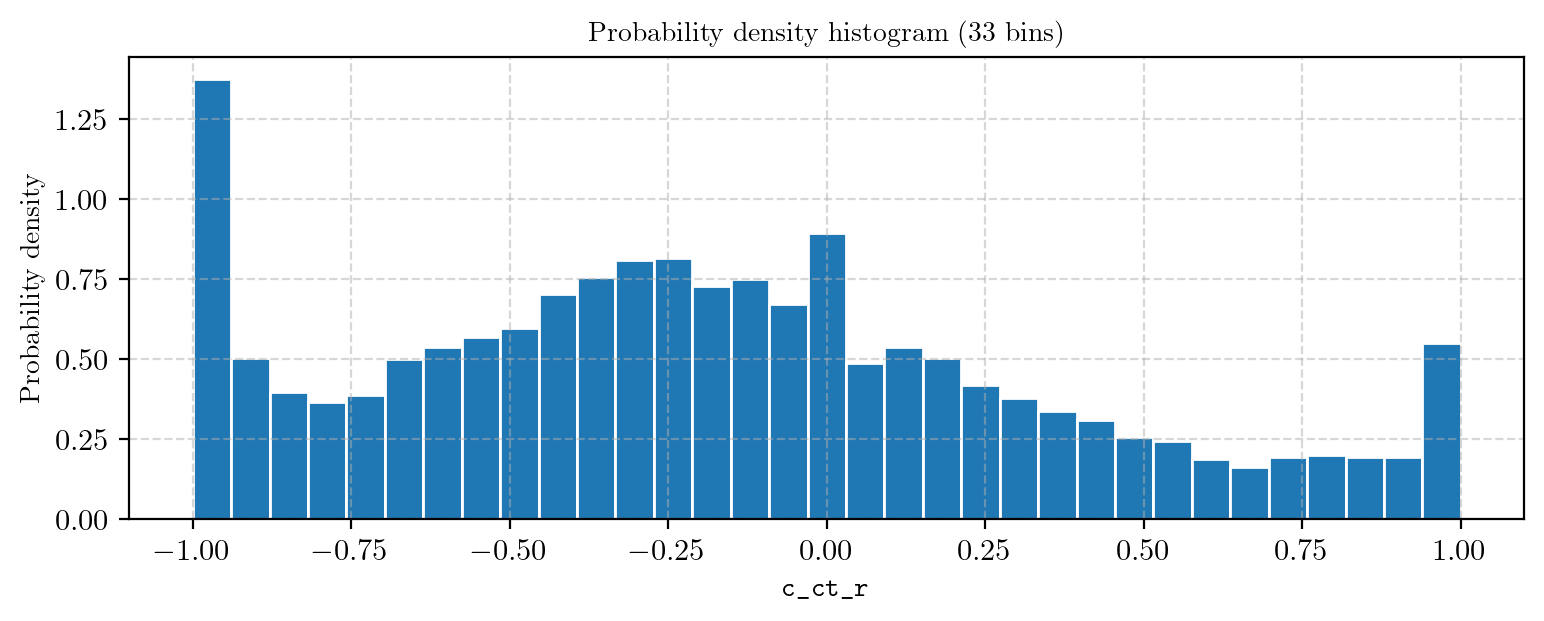

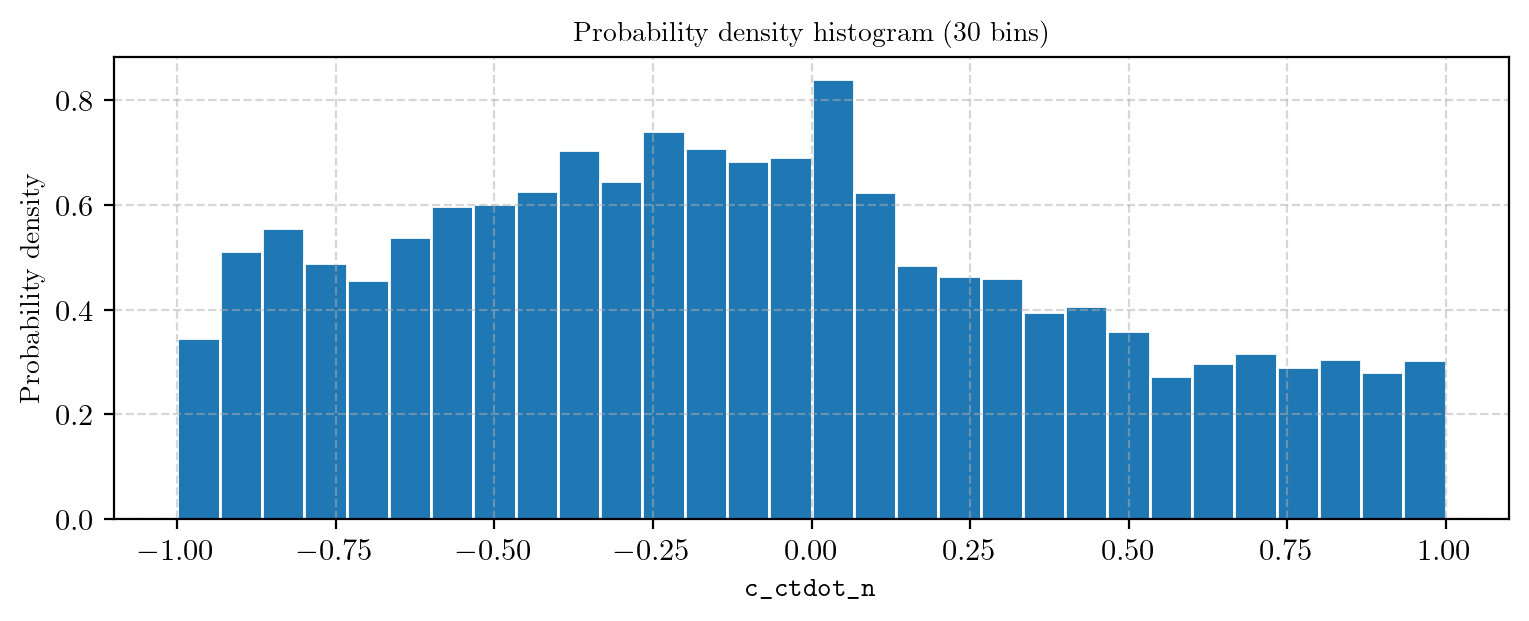

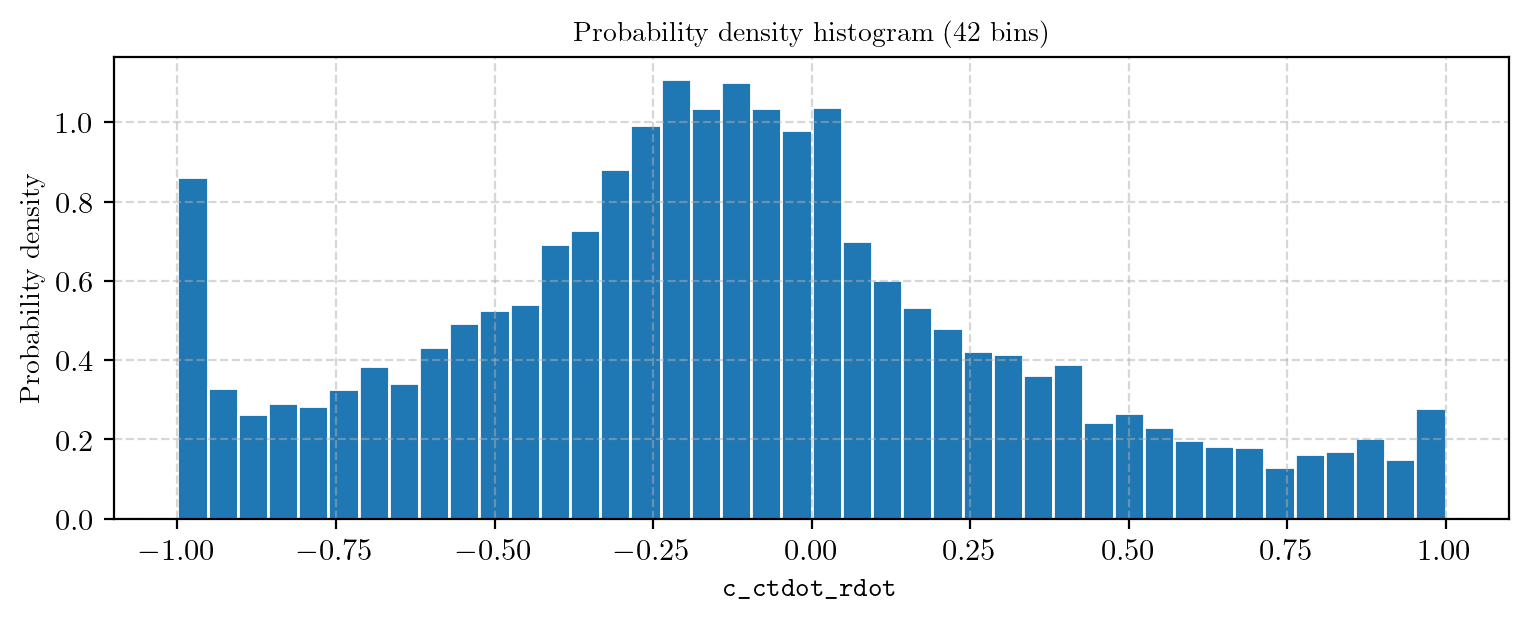

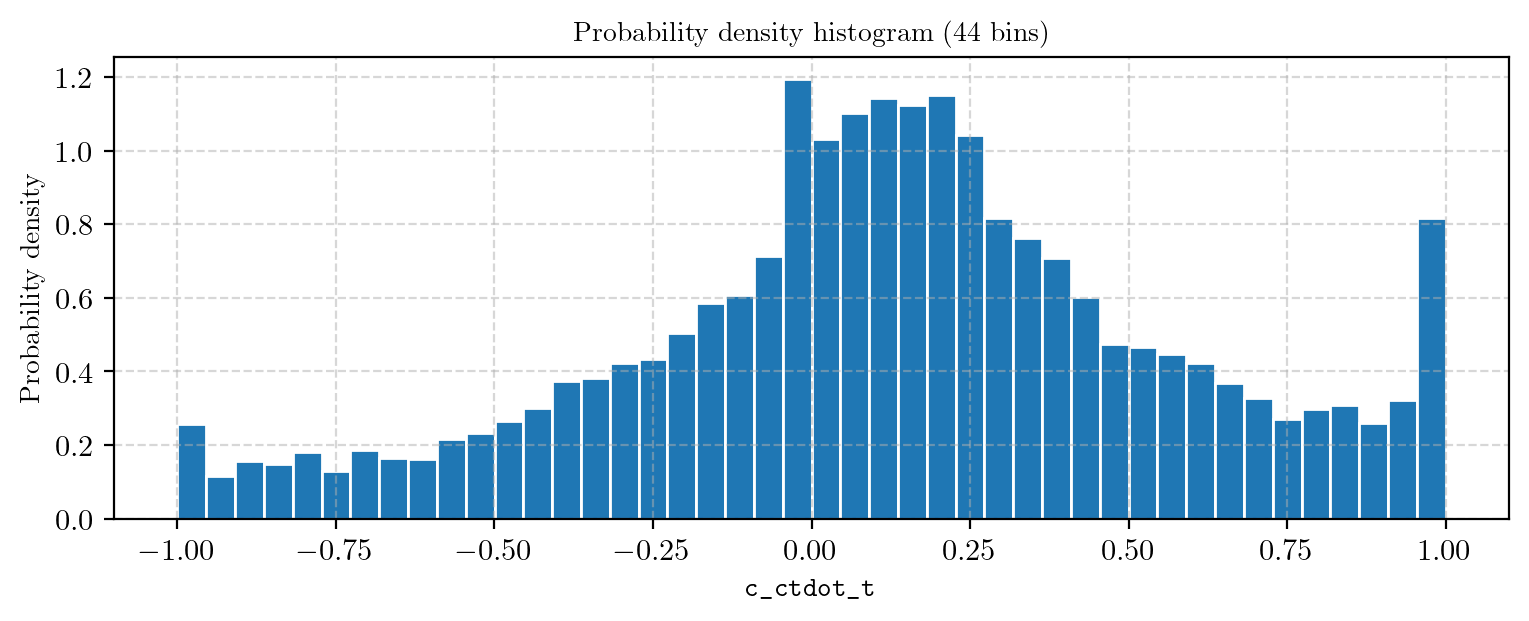

In [5]:
# Features that can only be described by the non-parammetric approach
features = ["time_to_tca", "risk", "azimuth", "F10", "F3M", "SSN", "AP",
            "t_j2k_inc", "t_j2k_ecc", "t_h_per",
            "t_cd_area_over_mass", "t_cr_area_over_mass",
            "c_cd_area_over_mass", "c_cr_area_over_mass",
            "t_cndot_n", "t_crdot_r", "t_crdot_t", "t_ct_r", "t_ctdot_rdot",
            "c_cn_r", "c_cndot_n", "c_cndot_r", "c_cndot_tdot", "c_crdot_r",
            "c_ct_r", "c_ctdot_n", "c_ctdot_rdot", "c_ctdot_t"]


for feature in features:
    # Get feature data and cast it as numpy array
    data = df_lastCDM[feature].to_numpy()

    # Compute number of bins and bin width for Histogram representation
    bins = main.nbins(data, 'fd')

    plt.figure(figsize=(9,3))
    plt.hist(data, bins = bins['n'], ec='white', density=True)
    plt.xlabel(r'\texttt{' + feature + '}', fontsize=10)
    plt.ylabel('Probability density', fontsize=10)
    plt.title('Probability density histogram (%d bins)' % bins['n'], fontsize=10)
    plt.grid(True, linestyle="dashed", alpha=0.5)
    plt.show()

## Optimal bandwidth selection using Minimum Squared Error cross-validation (MSECV)

In order to estimate the optimal bandwidth that appropriately describes all features, different methods have been consider within the fields of statistics. However, none of these methods have successfully describe the characteristics of the features at hand.

In order to overcome this difficulty, we propose a computational method that is based on a MSE cross-validation to select an optimal bandwidth value as follows:

1. Cross-validation set-up: Define list of total number of batches (samples) `batches_list=[2, 3, 4, ...]` to consider within the croos-validation domain.
    

2. Perform the following operations for every sample `i` in `batches_list[i]`:

    1. Randomly associate a category label (following a uniform distribution) to all data points. For example, `batches_list[1] = 3` will create two samples containing ~33% of the total number of data points each using the categories `0`, `1`, and `3`.
    
    2. For every sample compute actual probability density `apd[i]` using `numpy.histogram()` function.
    
    3. Calculate the average of the actual probability density `avg_apd` of all samples.
    
    4. Find the bandwidth `bw` that minimizes the mean squared error between the `avg_apd` and the estimated probability density. To do so, it iterates over a range of bandwidth values doing the following operations in a loop until a given convergence accuracy is achieved in the selected bandwidth:
    
        1. Compute estimated probability density `epd` of the entire data using the Gaussian Kernel Density for a given bandwidth `bw`. 
      
        2. Calculate the MSE `avg_apd` vs `epd` and store it in an array `mse`.
      
        3. Get the bandwidth value `bw` that minimizes the MSE and narrow down the bandwidth range for a next iteration until convergence accuracy is achieved. Once the convergence accuracy is achieved, store the best `bw` value in an array.

3. Finally, compute average of all bandwidths that minimize MSE obtained from all sets of batches in `batches_list` and round the value up using one order of magnitude less in order to mitigate overfitting (i.e. if final `bw=0.0013`, it will round up to `bw=0.002`).
      

In [22]:
def msecv(data: np.ndarray, bins:dict, conv_accuracy:float = 1e-5, 
                    n_batches_max:int = 10, print_log:bool = True) -> dict:
    
    # Exclude NaN and non-finite numbers from data
    data = data[np.isfinite(data)]

    # Create an array with the number of batches to process per iteration 
    batches_list = np.arange(start=2, stop=n_batches_max + 1, step=1, dtype=np.int32)
    
    # Initialize arry to store best bandwidth per group of batches
    best_bandwidths = np.zeros(len(batches_list))

    for i, batches in enumerate(batches_list):
        
        # Create an array with random values between 0 and the total number of batches
        # of the size of the entire array of data (following a uniform distribution).
        batches_categories = np.random.randint(low=0, high=batches, size=len(data))

        # Initialize array to store actual probabilty densities (apds) from every batch
        apds = np.zeros((bins['n'], batches))

        # Iterate over all batches categories (0 to number of batches)
        for c in range(batches):
            
            # Get sample of data corresponding to a specific batch category "c"
            sample = data[batches_categories==c]
            
            # Get actual probability density from the sample using number of bins obtained
            # from the entire array of data and store it in the apds array.
            apds[:,c], bin_edges = np.histogram(sample, bins = bins['n'], density=True)

        # Get array of bin centers to which the actual probability density are associated
        bin_centers = bin_edges[:-1] + bins['width']/2

        # Compute average of all actual probability densities from all batches
        avg_apd = np.mean(apds, axis=1, dtype=np.float64)

        # Initialize bandwidth array to evaluate estimated probability density from kernel
        bandwidths, step = np.linspace(bins['width']/100, bins['width'], 100, retstep=True)

        # Initialize best_bw
        best_bw = 0.0
        while True:

            # Initialize mean squared errors array associated to every bandwidth
            mse = np.zeros(len(bandwidths))

            # Iterate over all the bandwidths to compute the MSE from the actual vs estimated 
            # probability densities
            for b, bandwidth in enumerate(bandwidths):

                # Get estimated probability distribution using the bandwidth "b"
                epd = bws.kde(data, bin_centers, bandwidth=bandwidth)
                
                # Compute MSE from actual vs estimated probability densities
                mse[b] = ((epd - avg_apd)**2).mean()
                
            # Get bandwidth that minimizes MSE and check accuracy vs best_bw
            bw = bandwidths[np.argmin(mse)]

            # Check if convergence accuracy is achieved to stop iterations
            if abs(1 - best_bw/bw) <= conv_accuracy: break
            
            # Update best_bw and bandwidths array to increase final bandwidth accuracy
            best_bw = bw
            bandwidths, step = np.linspace(bw-step, bw+step, 100, retstep = True)
            
        # Add best bandwidth from this group of batches to final array
        best_bandwidths[i] = best_bw 

        if print_log: print(f'Batches = {batches:2} ({len(data)//batches} d.p. per batch)  '
                            f'Best bandwidth = {best_bw:.5f}  MSE(apd, epd) = {mse.min():.4e}')

    # Round-up best bandwidth from all groups of batches using one order of magnitude less
    scale = 10**main.order_of_magnitude(best_bandwidths.mean())
    best_bw = (math.ceil(best_bandwidths.mean()/scale)*scale)
    
    
    # Compute final estimated probability density using the best bandwidth and compare it
    # with actual probability density using MSE
    epd = bws.kde(data, bin_centers, kernel='gaussian', bandwidth=best_bw)
    apd, bin_edges = np.histogram(data, bins = bins['n'], density=True)
    estimated_mse = ((epd - apd)**2).mean()
    
    if print_log: print(f'\nFinal Optimal bandwidth = {best_bw}\t MSE(apd, epd) = {estimated_mse}')
    
    return {'bw': best_bw, 'estimated_mse':estimated_mse}

### Results

Batches =  2 (6577 d.p. per batch)  Best bandwidth = 3.44256  MSE(apd, epd) = 9.6544e-08
Batches =  3 (4384 d.p. per batch)  Best bandwidth = 3.39255  MSE(apd, epd) = 1.2341e-07
Batches =  4 (3288 d.p. per batch)  Best bandwidth = 3.43582  MSE(apd, epd) = 9.4838e-08
Batches =  5 (2630 d.p. per batch)  Best bandwidth = 3.50063  MSE(apd, epd) = 1.2355e-07
Batches =  6 (2192 d.p. per batch)  Best bandwidth = 3.52478  MSE(apd, epd) = 4.9557e-08
Batches =  7 (1879 d.p. per batch)  Best bandwidth = 3.65221  MSE(apd, epd) = 2.6752e-07
Batches =  8 (1644 d.p. per batch)  Best bandwidth = 3.63728  MSE(apd, epd) = 1.6734e-07
Batches =  9 (1461 d.p. per batch)  Best bandwidth = 3.67882  MSE(apd, epd) = 4.4731e-08
Batches = 10 (1315 d.p. per batch)  Best bandwidth = 3.96595  MSE(apd, epd) = 3.5517e-08

Final Optimal bandwidth = 4	 MSE(apd, epd) = 2.370163335437112e-07


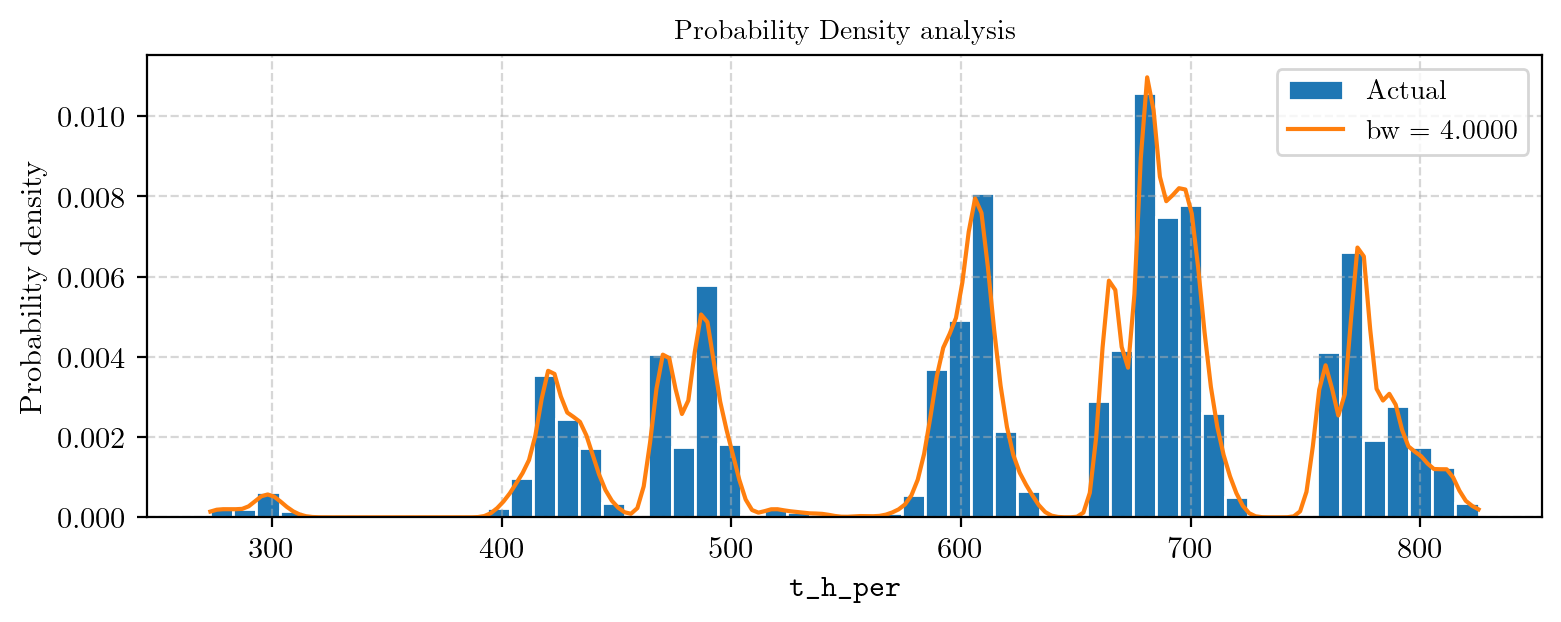

Batches =  2 (6577 d.p. per batch)  Best bandwidth = 0.00005  MSE(apd, epd) = 8.8486e+01
Batches =  3 (4384 d.p. per batch)  Best bandwidth = 0.00005  MSE(apd, epd) = 4.6769e+01
Batches =  4 (3288 d.p. per batch)  Best bandwidth = 0.00006  MSE(apd, epd) = 2.3127e+02
Batches =  5 (2630 d.p. per batch)  Best bandwidth = 0.00005  MSE(apd, epd) = 4.6507e+01
Batches =  6 (2192 d.p. per batch)  Best bandwidth = 0.00010  MSE(apd, epd) = 6.1875e+02
Batches =  7 (1879 d.p. per batch)  Best bandwidth = 0.00009  MSE(apd, epd) = 1.5391e+02
Batches =  8 (1644 d.p. per batch)  Best bandwidth = 0.00016  MSE(apd, epd) = 1.9448e+03
Batches =  9 (1461 d.p. per batch)  Best bandwidth = 0.00016  MSE(apd, epd) = 1.9776e+03
Batches = 10 (1315 d.p. per batch)  Best bandwidth = 0.00009  MSE(apd, epd) = 7.2602e+01

Final Optimal bandwidth = 0.0001	 MSE(apd, epd) = 977.7865469995372


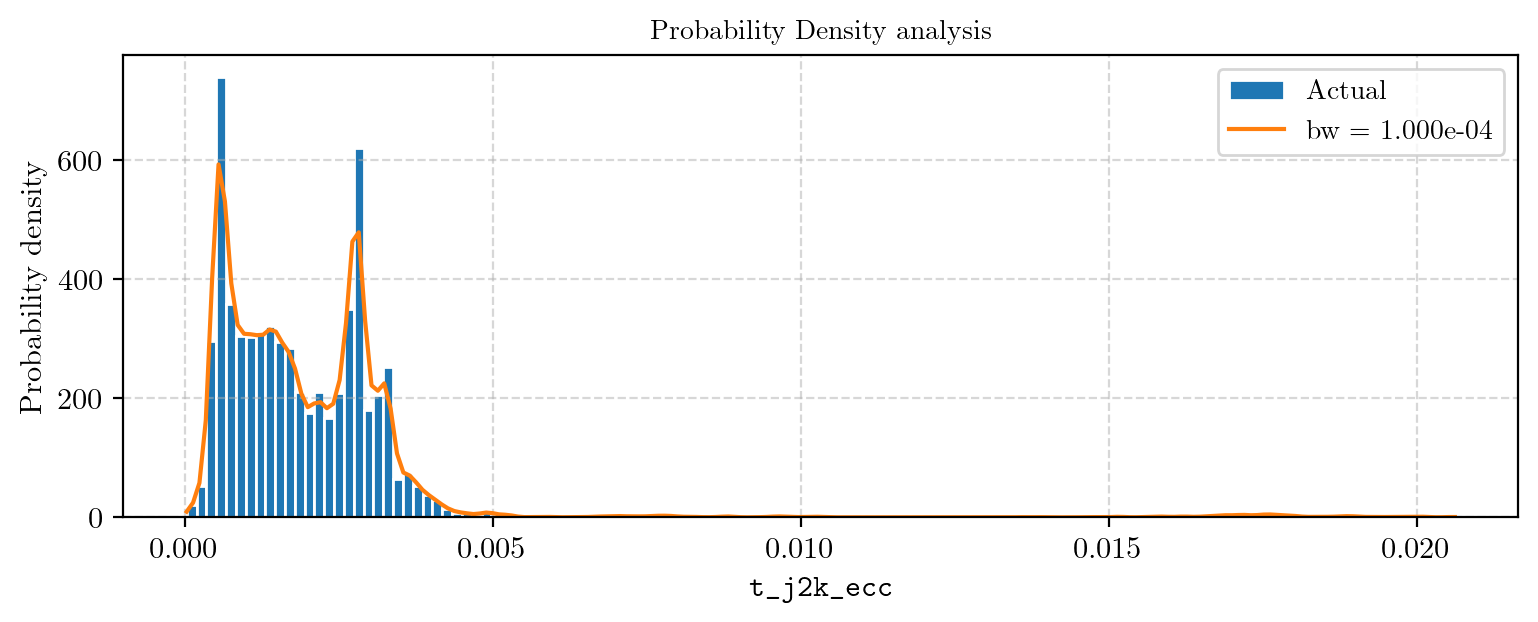

Batches =  2 (6577 d.p. per batch)  Best bandwidth = 0.20018  MSE(apd, epd) = 5.0898e-04
Batches =  3 (4384 d.p. per batch)  Best bandwidth = 0.20098  MSE(apd, epd) = 5.0899e-04
Batches =  4 (3288 d.p. per batch)  Best bandwidth = 0.19869  MSE(apd, epd) = 5.4722e-04
Batches =  5 (2630 d.p. per batch)  Best bandwidth = 0.19992  MSE(apd, epd) = 5.4053e-04
Batches =  6 (2192 d.p. per batch)  Best bandwidth = 0.19862  MSE(apd, epd) = 5.3042e-04
Batches =  7 (1879 d.p. per batch)  Best bandwidth = 0.20019  MSE(apd, epd) = 5.3563e-04
Batches =  8 (1644 d.p. per batch)  Best bandwidth = 0.19961  MSE(apd, epd) = 5.5179e-04
Batches =  9 (1461 d.p. per batch)  Best bandwidth = 0.19941  MSE(apd, epd) = 5.4200e-04
Batches = 10 (1315 d.p. per batch)  Best bandwidth = 0.19895  MSE(apd, epd) = 5.5245e-04

Final Optimal bandwidth = 0.2	 MSE(apd, epd) = 0.0005182277192194462


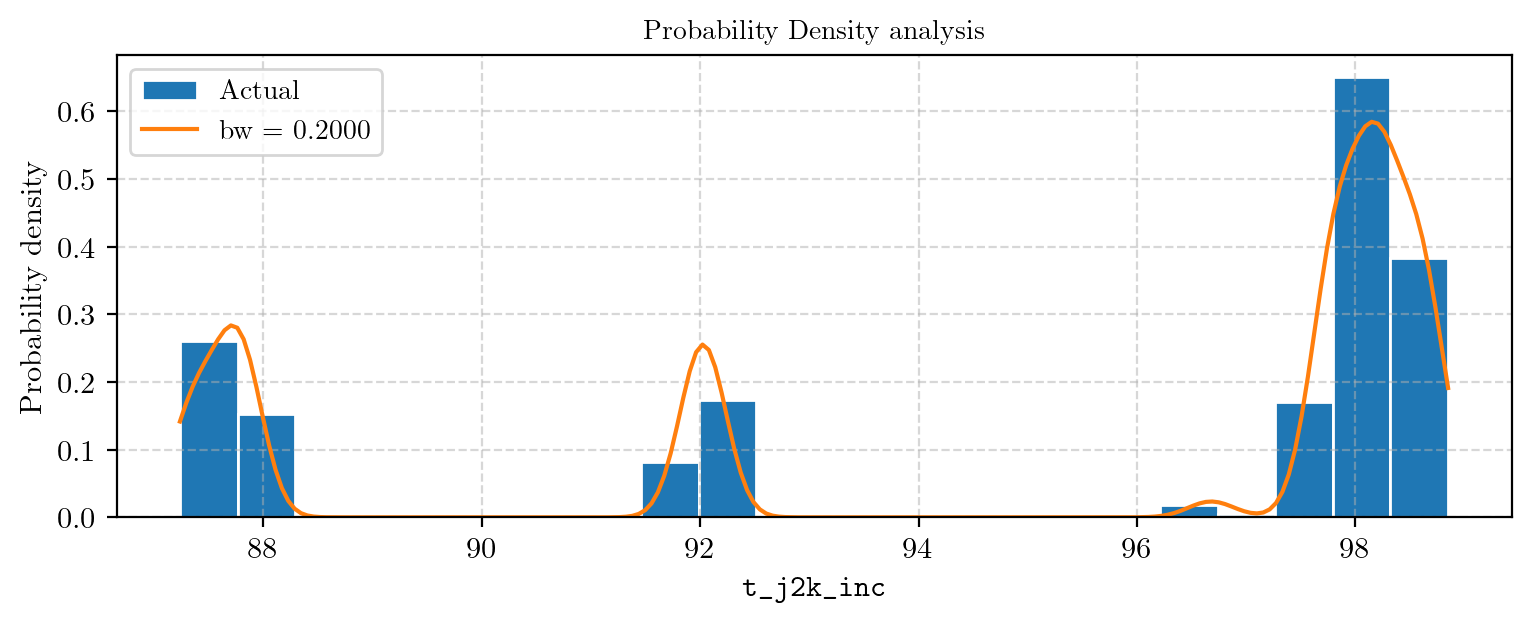

In [24]:
# Iterate over all features that cannot be described through statistical models.
for feature in ['t_h_per', 't_j2k_ecc', 't_j2k_inc']:
    
    # Get feature data and cast it as a numpy array
    data = df_lastCDM[feature].to_numpy()
    
    # Shuffle data
    np.random.shuffle(data)
    
    # Get results from the cross-validation
    bw = msecv(data, bins=main.nbins(data, 'fd')) 

    # Plot estimated probability density function vs actual density for visual comparison
    bws.plot_kde(data, [bw['bw']], figsize=(9,3), xlabel=r'\texttt{' + feature + '}')


### Comparison with `statsmodels`  library


Bandwidth selection method: Normal reference


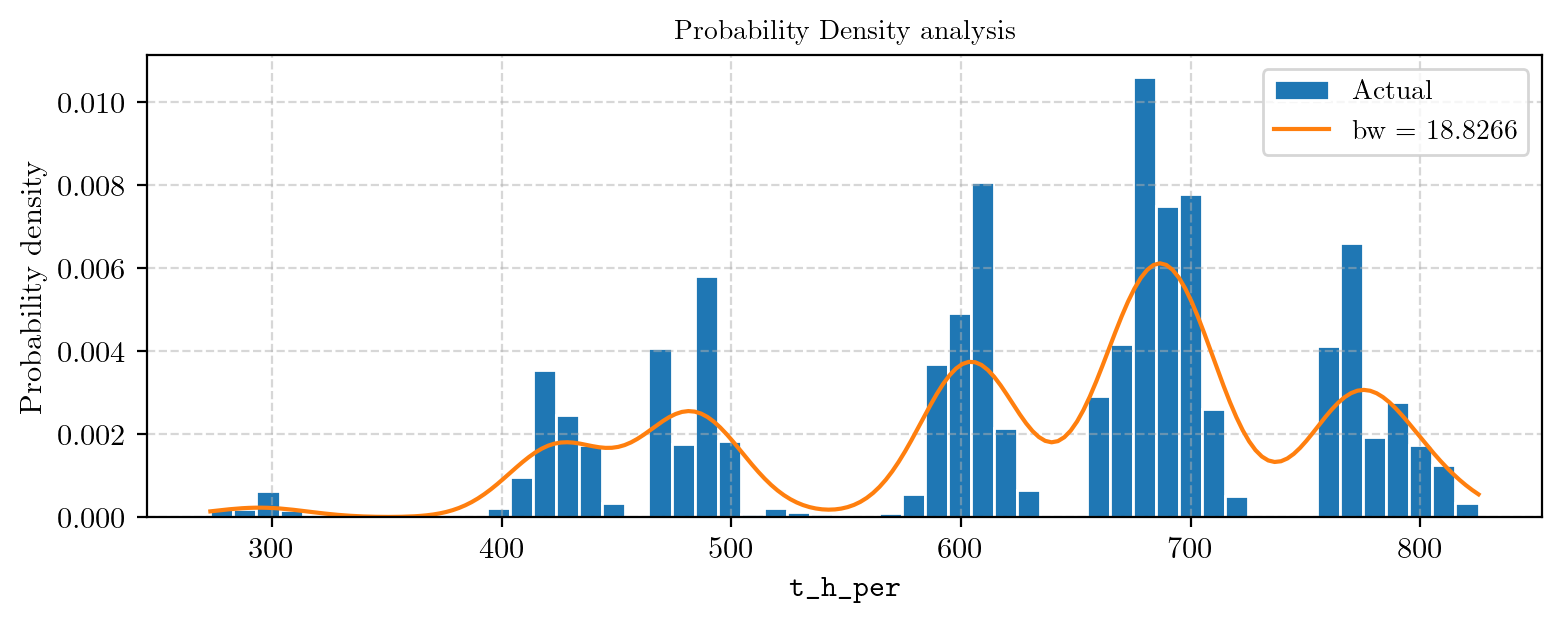


Bandwidth selection method: CV Max. likelihood


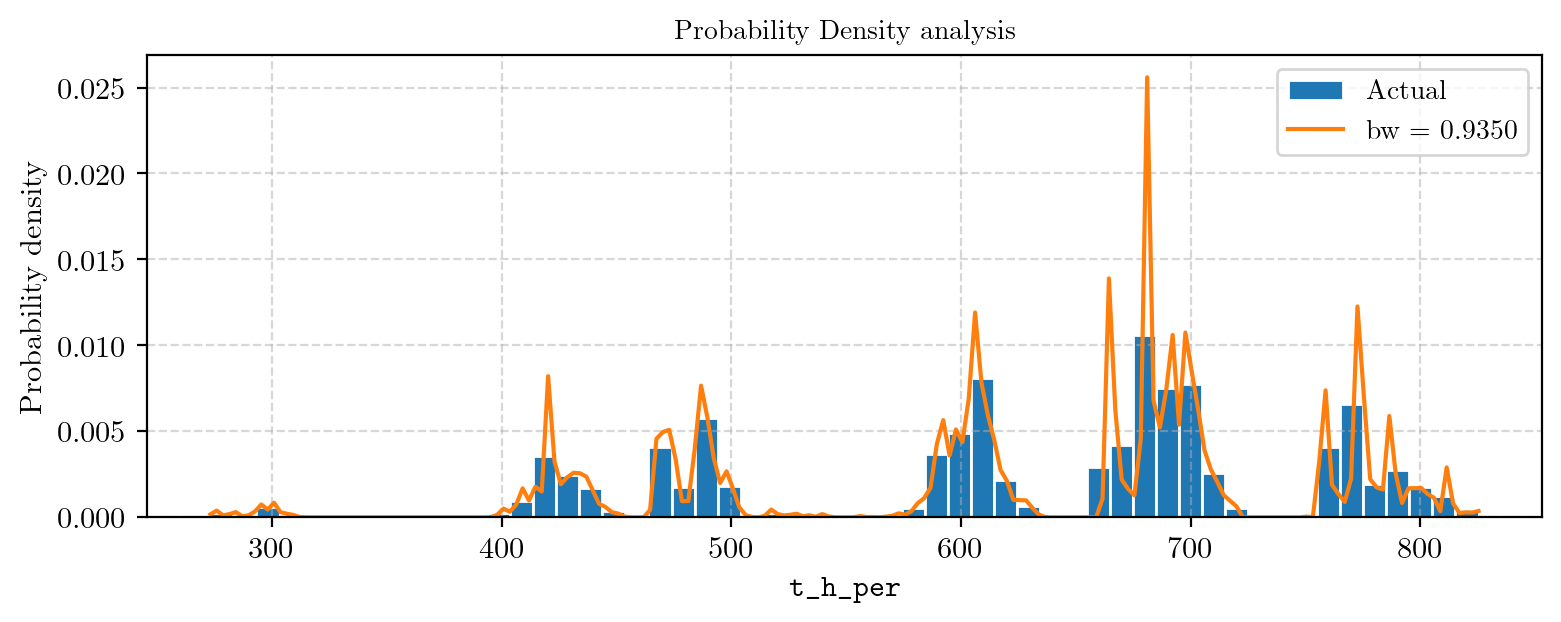


Bandwidth selection method: CV least squares


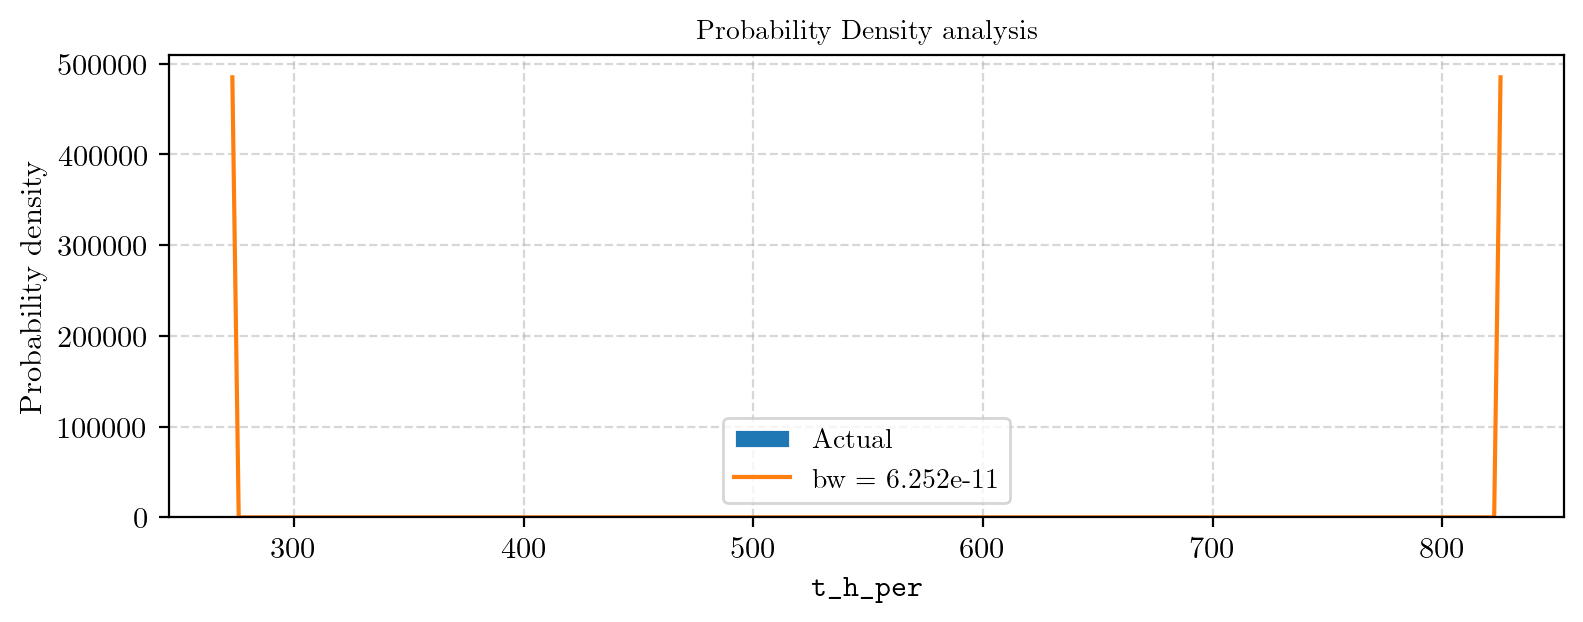

[1.88266362e+01 9.34950969e-01 6.25230707e-11]
['Normal reference', 'CV Max. likelihood', 'CV least squares']

Bandwidth selection method: Normal reference


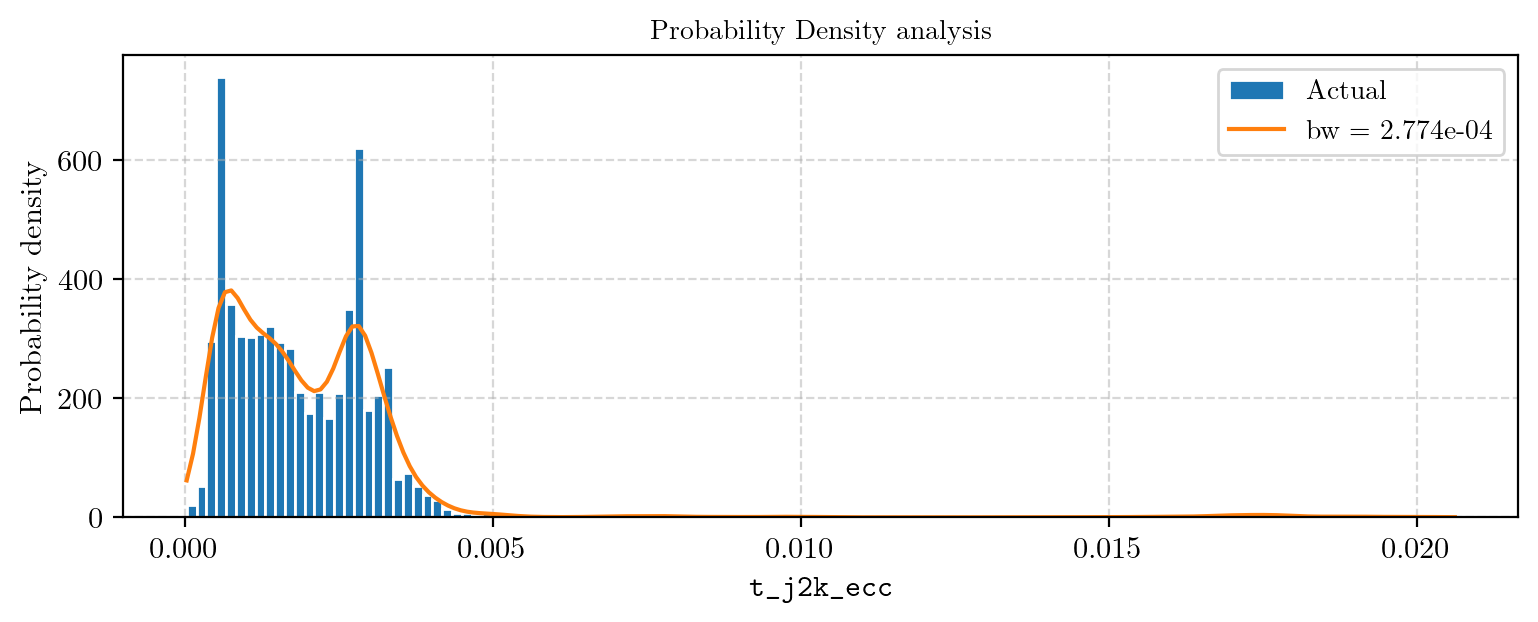


Bandwidth selection method: CV Max. likelihood


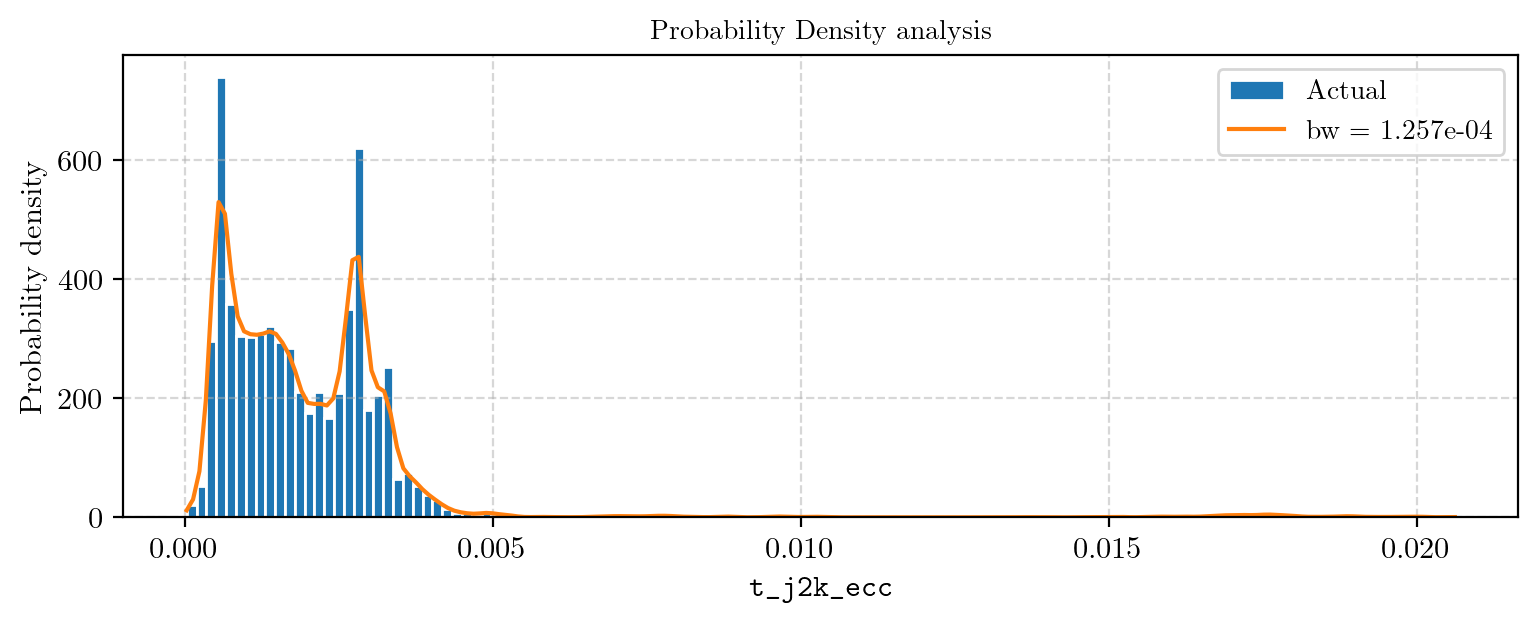


Bandwidth selection method: CV least squares


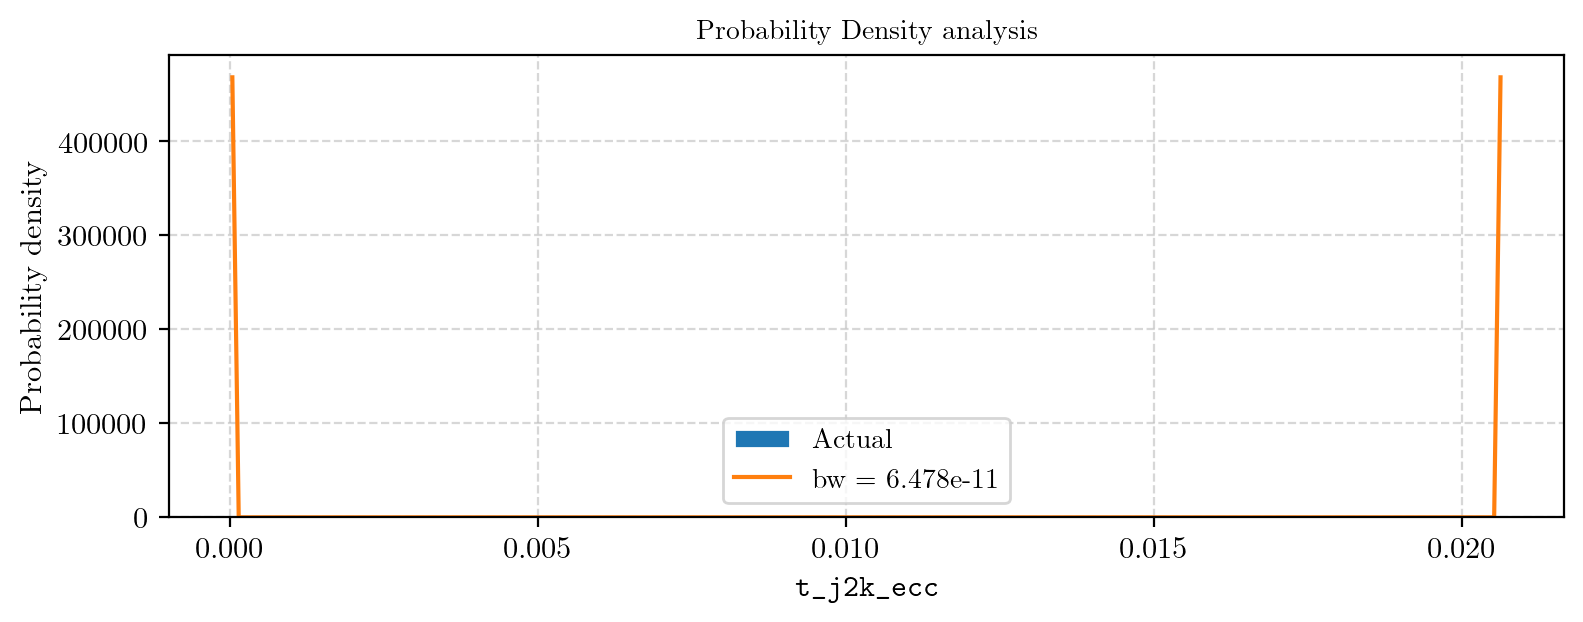

[2.77447113e-04 1.25718223e-04 6.47843408e-11]
['Normal reference', 'CV Max. likelihood', 'CV least squares']

Bandwidth selection method: Normal reference


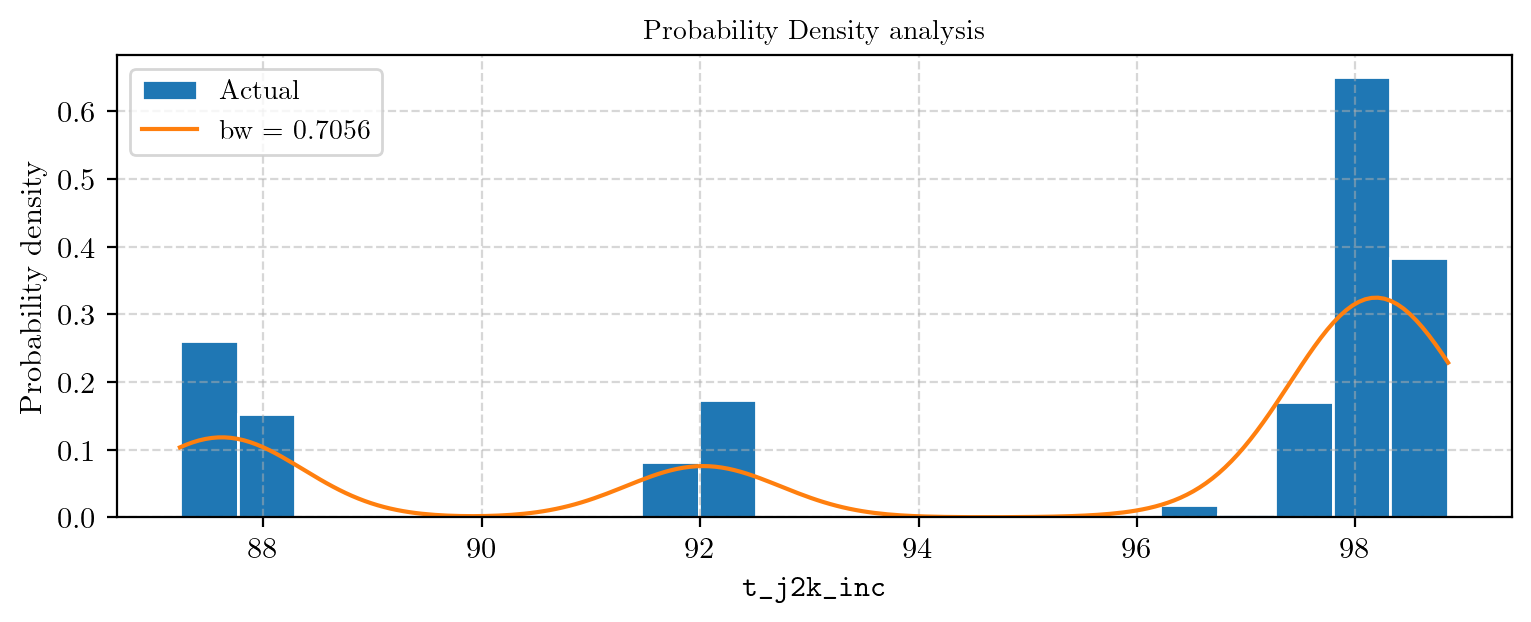


Bandwidth selection method: CV Max. likelihood


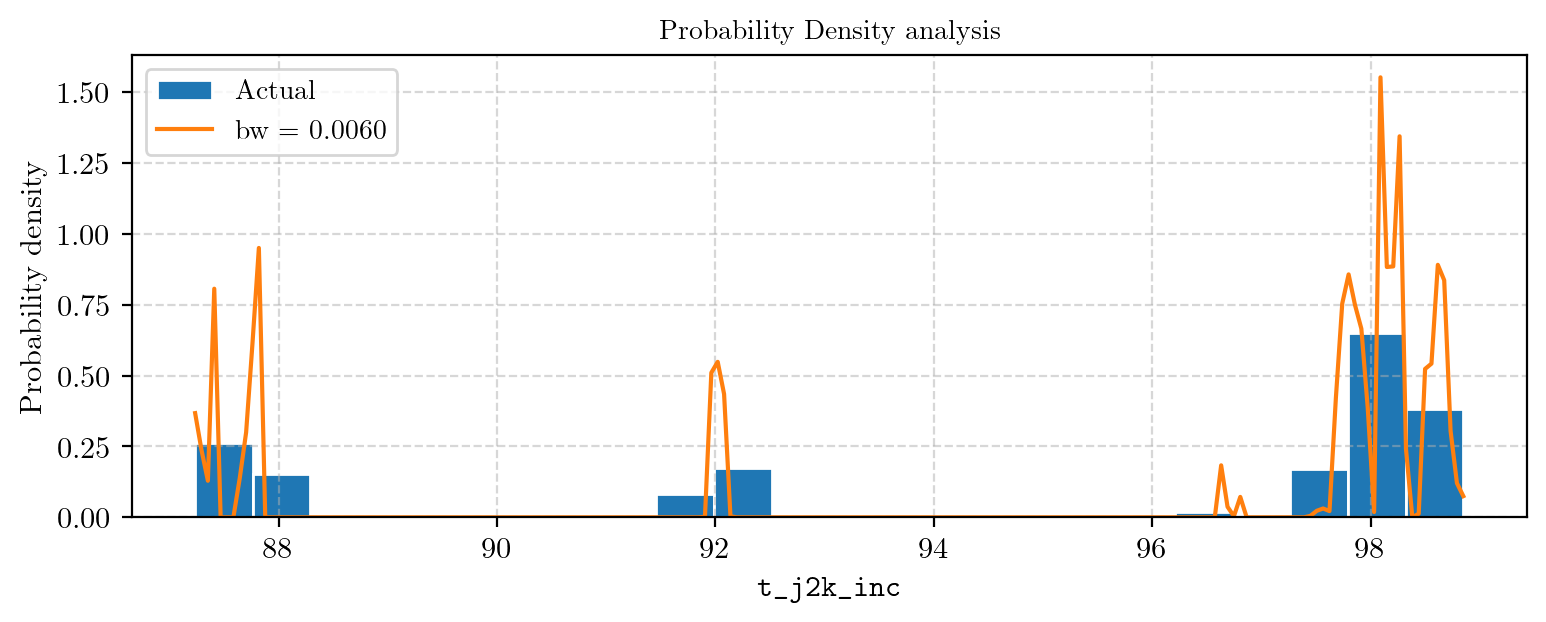


Bandwidth selection method: CV least squares


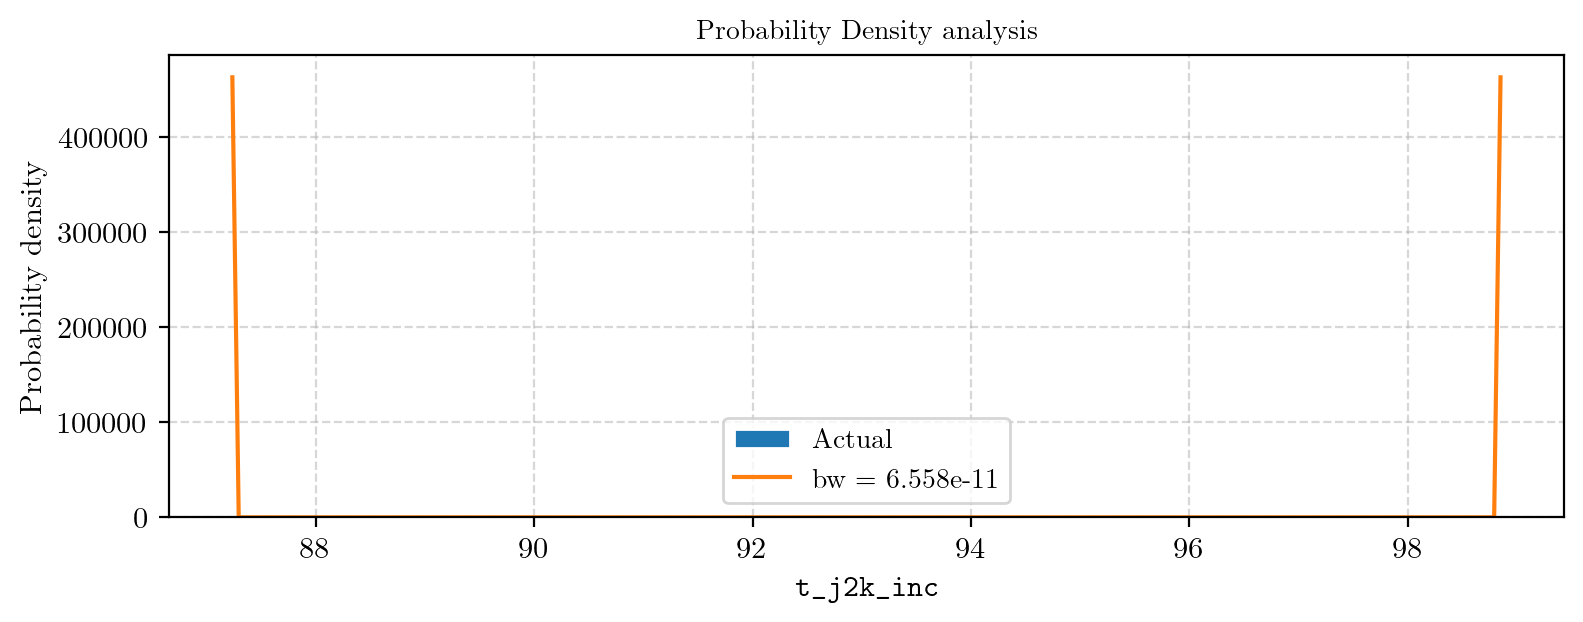

[7.05633422e-01 5.95205926e-03 6.55802489e-11]
['Normal reference', 'CV Max. likelihood', 'CV least squares']


In [44]:
import statsmodels as sm

# Iterate over all features that cannot be described through statistical models.
for feature in ['t_h_per', 't_j2k_ecc', 't_j2k_inc']:
    
    # Get feature data and cast it as a numpy array
    data = df_lastCDM[feature].to_numpy()
    
    # Shuffle data
    np.random.shuffle(data)
    
    # Set default options for the statsmodels estimator
    settings = sm.nonparametric.kernel_density.EstimatorSettings(efficient=True, n_sub=len(data)//10)

    # Bandwidth selection methods:
    # normal_reference: normal reference rule of thumb (default)
    # cv_ml: cross validation maximum likelihood
    # cv_ls: cross validation least squares
    
    estimated_bandwidths = np.zeros(3)
    bw_labels = ['Normal reference', 'CV Max. likelihood', 'CV least squares']
    
    for m, method in enumerate(['normal_reference', 'cv_ml', 'cv_ls']):
        epd = sm.api.nonparametric.KDEMultivariate(data=data, var_type='c', bw=method, defaults=settings)

        estimated_bandwidths[m] = epd.bw[0]
        
        print('\nBandwidth selection method: ' + bw_labels[m])
        
        bws.plot_kde(data, [epd.bw[0]], figsize=(9,3), 
                 xlabel=r'\texttt{' + feature + '}')
    